# Notebook to test the scOPE code

Andrew Ashford, Pathways + Omics Group, OHSU
5/24/2024

This workflow will use bulk RNA-seq counts and variant call data to train logistic ridge regression classifiers to predict the presence or absence of cancer-associated mutations. I will then apply the models to single-cell data and perform additional experiments to determine clonal structures. This notebook is meant to implement and debug/test the code for this workflow as I write it.

NOTE: This notebook differs from code_test_notebook.ipynb in that I'm using integrated data and its PCs to train and test the model. You can refer to integrating_scRNA_and_bulk_RNA_AML_data.ipynb for steps taken to do this and where the integrated data object was saved.

In [3]:
# Import modules
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score


In [4]:
# Load in the data like so
# Specify the path to the saved file
#file_path = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/training/BeatAML/integrated_BeatAML_vanGalen_data/integrated_data.h5ad'

# Scanorama-integrated data with 100-variable latent space as .X
file_path = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/testing/vanGalen_all_h5ad/Scanorama-integrated_Beat_AML_vanGalen_AML_adata.h5ad'

# Combined data - both data types are normalized and scaled
#file_path = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/testing/vanGalen_all_h5ad/combined_Beat_AML_vanGalen_AML_adata.h5ad'

# Load the AnnData object
integrated_data = sc.read_h5ad(file_path)


In [ ]:
# Get top 2000 most variable genes for feature input into model
sc.pp.highly_variable_genes(integrated_data, n_top_genes=1000)

# Subset the AnnData object to keep only the highly variable genes
integrated_data = integrated_data[:, integrated_data.var['highly_variable']].copy()

# Check the resulting AnnData object
print(integrated_data)


In [5]:
# Verify the contents of the loaded data
print(integrated_data)
print(integrated_data.X)
print(integrated_data.X.min())
print(integrated_data.X.max())
#print(integrated_data.obsm['X_pca'])
#print(integrated_data.obsm['X_pca'].shape)


AnnData object with n_obs × n_vars = 43375 × 100
    obs: 'orig.ident', 'NumberOfReads', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRefined', 'CellType', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch'
    var: 'mean', 'std'
    uns: 'batch_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
[[ 5.33728636e-01  4.56122539e-01 -5.49870633e-01 ... -1.04860181e+00
   2.70313051e+00  1.58738575e-01]
 [ 2.92798229e-01 -1.56300215e-01  1.77061357e+00 ... -2.19875218e+00
   7.06249315e-01  3.95891909e-02]
 [ 3.65474594e-01  1.45822513e+00  1.64700819e+00 ... -9.71878518e-01
   4.50370249e-02 -1.04927603e+00]
 ...
 [-1.72391602e+00 -1.48192778e-01 -7.98023657e-02 ... -1.13686793e-03
  -9.84392543e-01  8.13294278e-01]
 [ 1.20874894e+00  1.16265796e+00  1.43208432e+00 ... -9.40546281e-01
   6.55943428e-01  1.59946526e+00]

In [6]:
print(integrated_data.obs)
print(integrated_data.X)
print(integrated_data.X.max())
print(integrated_data.X.min())


                        orig.ident  NumberOfReads  CyclingScore CyclingBinary  \
BM1_AGGCGGGCGTGN-scRNA        35.0        90005.0        -0.101            no   
BM1_ATAACATTTCAC-scRNA        35.0       641816.0        -0.600            no   
BM1_ACGCTCTGGCCN-scRNA        35.0       343429.0         0.802           yes   
BM1_TTGCACAGAGGA-scRNA        35.0       270399.0        -0.527            no   
BM1_TGTCGTATGGAT-scRNA        35.0       166596.0        -0.372            no   
...                            ...            ...           ...           ...   
BA3385R-bulk                   NaN            NaN           NaN           NaN   
BA3242R-bulk                   NaN            NaN           NaN           NaN   
BA3446R-bulk                   NaN            NaN           NaN           NaN   
BA3416R-bulk                   NaN            NaN           NaN           NaN   
BA3123R-bulk                   NaN            NaN           NaN           NaN   

                       MutT

In [50]:
specific_patient_adata = integrated_data[integrated_data.obs_names.str.startswith('AML556.D0')]

print(specific_patient_adata)


View of AnnData object with n_obs × n_vars = 2262 × 1000
    obs: 'orig.ident', 'NumberOfReads', 'CyclingScore', 'CyclingBinary', 'MutTranscripts', 'WtTranscripts', 'PredictionRefined', 'CellType', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'dataset'
    var: 'highly_variable', 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean-1', 'std-1', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'


In [39]:
# UMAP visualization of integrated data as a check
sc.pp.neighbors(integrated_data, use_rep='X')
sc.tl.umap(integrated_data)


In [ ]:
#sc.pl.umap(integrated_data, color=['cell_type'])
sc.pl.umap(integrated_data, color=['CellType'])


KeyError: 'Could not find key batch in .var_names or .obs.columns.'

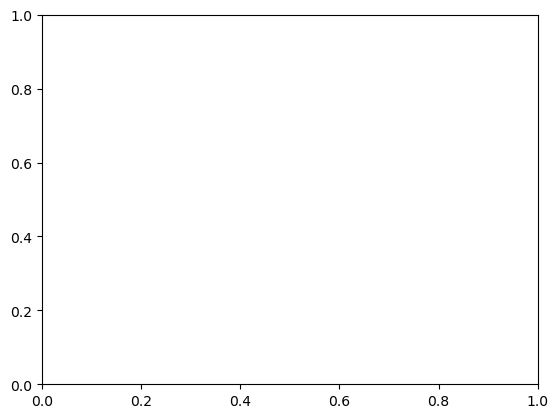

In [41]:
#sc.pl.umap(integrated_data, color=['dataset'])
sc.pl.umap(integrated_data, color=['batch'])


In [15]:
# UMAP visualization of integrated data as a check
sc.pp.neighbors(integrated_data, use_rep='X_pca')
sc.tl.umap(integrated_data)


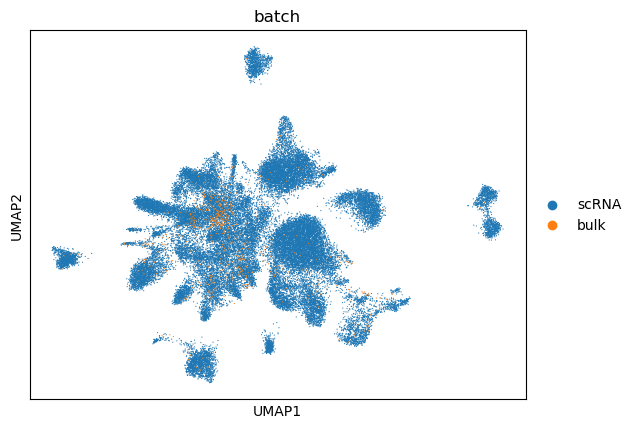

In [17]:
#sc.pl.umap(integrated_data, color=['dataset'])
sc.pl.umap(integrated_data, color=['batch'])


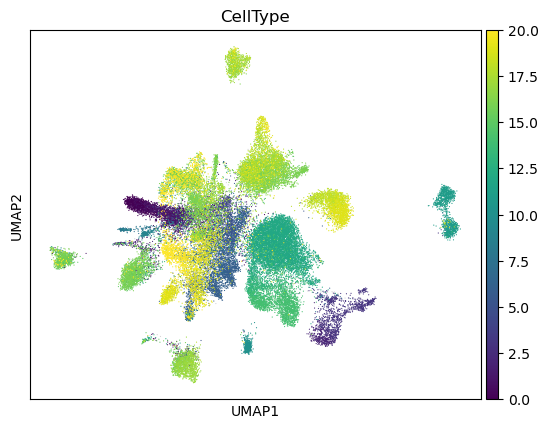

In [18]:
#sc.pl.umap(integrated_data, color=['cell_type'])
sc.pl.umap(integrated_data, color=['CellType'])


In [42]:
print(integrated_data.obsm['X_pca'])
print(integrated_data.obsm['X_pca'].shape)


KeyError: 'X_pca'

In [7]:
# Load the bulk RNA-seq mutation data
mut_data = pd.read_csv('/home/groups/precepts/ashforda/scOPE_github_stuff/data/training/BeatAML/publicly_available_and_raw_counts/beataml_wes_wv1to4_mutations_dbgap.txt', sep='\t')

# Load the integrated AnnData object
#adata = sc.read_h5ad('/home/groups/precepts/ashforda/scOPE_github_stuff/data/training/BeatAML/integrated_BeatAML_vanGalen_data/integrated_data.h5ad')
adata = sc.read_h5ad('/home/groups/precepts/ashforda/scOPE_github_stuff/data/testing/vanGalen_all_h5ad/Scanorama-integrated_Beat_AML_vanGalen_AML_adata.h5ad')
#adata = sc.read_h5ad('/home/groups/precepts/ashforda/scOPE_github_stuff/data/testing/vanGalen_all_h5ad/combined_Beat_AML_vanGalen_AML_adata.h5ad')


In [8]:
# Scale all the .obsm['X_pca'] values
#scaler = StandardScaler()
#adata.obsm['X_pca'] = scaler.fit_transform(adata.obsm['X_pca'])
print(adata.obsm['X_pca'])
print(adata.obsm['X_pca'].shape)


[[-1.0544937   0.735577   -1.1351676  ...  1.9977621   0.15040958
   0.24633902]
 [-0.5546137   0.28559676 -2.191501   ... -0.22898728  0.70998377
  -1.2771353 ]
 [ 0.8915451  -0.05047626 -1.8551278  ...  0.2661664  -0.08699474
   0.15458593]
 ...
 [ 1.6875799  -1.3533969   0.40766987 ...  1.2168149   1.6026018
  -0.1429827 ]
 [-0.590912   -1.0745909   0.54620093 ...  0.50464696 -0.6581712
  -0.62667614]
 [-0.2033931  -0.16435733  0.57189584 ... -1.1292096   0.06780091
   1.3972839 ]]
(43375, 50)


In [9]:
# Extract bulk RNA-seq data
#bulk_data = adata[adata.obs['dataset'] == '1']
bulk_data = adata[adata.obs['batch'] == 'bulk']

# Prepare the bulk RNA-seq data for model training
# Using the PCA data
# NOTE: Using .X instead of .obsm['X_pca']
#X_pca = bulk_data.obsm['X_pca']
X_pca = bulk_data.X


In [10]:
print(X_pca)
print(X_pca.shape)


[[ 5.87148952e-01  1.60769887e+00  1.81858001e+00 ...  8.32371602e-02
   1.41887170e-01 -5.17121190e-02]
 [ 5.17385410e-01  1.61850754e+00  2.05066712e+00 ...  7.51348400e-02
   1.01213192e-01 -4.14282003e-02]
 [ 5.00198945e-01  1.64395528e+00  2.25044406e+00 ...  8.97325479e-02
   2.67186869e-01  1.58408804e-01]
 ...
 [-1.72391602e+00 -1.48192778e-01 -7.98023657e-02 ... -1.13686793e-03
  -9.84392543e-01  8.13294278e-01]
 [ 1.20874894e+00  1.16265796e+00  1.43208432e+00 ... -9.40546281e-01
   6.55943428e-01  1.59946526e+00]
 [ 8.59070619e-01 -5.70072625e-01  1.82551545e+00 ... -1.42900460e-01
  -7.82596020e-01  7.30024077e-01]]
(707, 100)


In [11]:
bulk_data.obs_names = bulk_data.obs_names.str.replace('R-bulk', 'D')


In [12]:
print(X_pca)
print(X_pca.shape)


[[ 5.87148952e-01  1.60769887e+00  1.81858001e+00 ...  8.32371602e-02
   1.41887170e-01 -5.17121190e-02]
 [ 5.17385410e-01  1.61850754e+00  2.05066712e+00 ...  7.51348400e-02
   1.01213192e-01 -4.14282003e-02]
 [ 5.00198945e-01  1.64395528e+00  2.25044406e+00 ...  8.97325479e-02
   2.67186869e-01  1.58408804e-01]
 ...
 [-1.72391602e+00 -1.48192778e-01 -7.98023657e-02 ... -1.13686793e-03
  -9.84392543e-01  8.13294278e-01]
 [ 1.20874894e+00  1.16265796e+00  1.43208432e+00 ... -9.40546281e-01
   6.55943428e-01  1.59946526e+00]
 [ 8.59070619e-01 -5.70072625e-01  1.82551545e+00 ... -1.42900460e-01
  -7.82596020e-01  7.30024077e-01]]
(707, 100)


In [13]:
print(mut_data)


      dbgap_sample_id              capture_type seqnames  pos_start  \
0             BA2336D               NexteraV1.2        4  106156042   
1             BA2336D               NexteraV1.2        4  106190829   
2             BA2336D               NexteraV1.2        5  170837543   
3             BA2643D               NexteraV1.2       11   32456651   
4             BA2643D               NexteraV1.2        2   25457242   
...               ...                       ...      ...        ...   
11716         BA3100D  Nimblegen Custom Capture        2   25457242   
11717         BA3100D  Nimblegen Custom Capture        2   25457242   
11718         BA3100D  Nimblegen Custom Capture        5  170837543   
11719         BA3100D  Nimblegen Custom Capture        1  115258747   
11720         BA3100D  Nimblegen Custom Capture        1  115258747   

         pos_end ref    alt genotyper  tumor_only  total_reads  ...  \
0      106156043  TC      T   varscan           1          151  ...   
1    

In [14]:
# Ensure the mutation labels are binary
mutations = mut_data['symbol'].unique()

# Modify the sample IDs to match between RNA and mutation data
bulk_data.obs['dbgap_sample_id'] = bulk_data.obs.index.str.replace('R-1', 'D')


In [15]:
print(mutations)
print(len(mutations))
print(set(mutations))
print(len(set(mutations)))


['TET2' 'NPM1' 'WT1' ... 'PNMA3' 'SLC41A2' 'PPP1R3A']
3333
{'THBS3', 'TAF4', 'ARHGEF10', 'EGR1', 'DUSP27', 'CEP170', 'PDZRN4', 'SETD7', 'ZNF429', 'SPICE1', 'PI4KA', 'CREB1', 'ADAMTS16', 'FGF23', 'IGHE', 'NEDD9', 'OIP5', 'MBIP', 'FSTL1', 'LAMP1', 'CARNS1', 'H3F3A', 'SQLE', 'NOL8', 'SLITRK5', 'HEG1', 'HDLBP', 'ACSM2A', 'PRLR', 'AKAP11', 'CHMP1A', 'SCNN1B', 'AMOTL2', 'TBL1XR1', 'TRPC3', 'LMAN2L', 'STK32B', 'SCN5A', 'MCUR1', 'RFX4', 'COL11A1', 'PDIA5', 'HCFC1', 'UBXN10', 'PDE4C', 'ZDHHC14', 'PLEKHG2', 'JMJD1C', 'CCDC58', 'CREB3L1', 'EZH2', 'CCDC42', 'LRRC63', 'PLEKHA4', 'PLRG1', 'BRIX1', 'DLGAP3', 'GLIS1', 'CTCFL', 'PARP3', 'ABCG8', 'ZFP36L2', 'SERPINI1', 'SH2D5', 'RHO', 'SLC9A3', 'ART5', 'SORL1', 'CT45A1', 'HIST1H1E', 'ANKRD53', 'RPS6', 'ANGPT4', 'ZNF227', 'IPO9', 'IFT140', 'ZNF598', 'C5orf60', 'WWC2', 'DCAF12L1', 'PLEKHA1', 'N4BP3', 'NFATC2', 'NPIPB15', 'ADHFE1', 'DACH2', 'FCHO1', 'TMEM67', 'NLRP12', 'CCDC68', 'NRK', 'NR1H4', 'KCNK15', 'MAP4K5', 'ZNF628', 'WDR52', 'WLS', 'PCDH7', 'NCEH1'

In [16]:
# Remove duplicate sample IDs in mutation data (if any)
mut_data = mut_data.drop_duplicates(subset=['dbgap_sample_id', 'symbol'])

# Create a binary matrix for mutation presence
mut_data_binary = pd.crosstab(mut_data['dbgap_sample_id'], mut_data['symbol'])


In [17]:
# Align mutation data with bulk RNA-seq data
bulk_sample_ids = bulk_data.obs['dbgap_sample_id']
mut_data_agg = mut_data_binary.reindex(bulk_sample_ids, fill_value=0)


In [18]:
print(mut_data_agg)


symbol           A1CF  A2M  A4GALT  AADAC  AADACL3  AADACL4  AAK1  AARS2  \
dbgap_sample_id                                                            
BA2392D             0    0       0      0        0        0     0      0   
BA2611D             0    0       0      0        0        0     0      0   
BA2506D             0    0       0      0        0        0     0      0   
BA2430D             0    0       0      0        0        0     0      0   
BA2448D             0    0       0      0        0        0     0      0   
...               ...  ...     ...    ...      ...      ...   ...    ...   
BA3385D             0    0       0      0        0        0     0      0   
BA3242D             0    0       0      0        0        0     0      0   
BA3446D             0    0       0      0        0        0     0      0   
BA3416D             0    0       0      0        0        0     0      0   
BA3123D             0    0       0      0        0        0     0      0   

symbol     

In [19]:
# Standardize the PCA data
#scaler = StandardScaler()
#X_pca_scaled = scaler.fit_transform(X_pca)
# Decided not to do this, but didn't want to mess up downstream stuff so I kept the variable name
X_pca_scaled = X_pca


In [20]:
# Initialize models
ridge_model = RidgeClassifierCV()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC(kernel='linear', probability=True, random_state=42)


In [21]:
# Function to train and evaluate model with Stratified K-Folds
def train_evaluate_model(X, y, model, model_name, cv_splits, mut_name, auc_dict):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    #scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    #print(f"{model_name} - Cross-validation accuracy: {np.mean(scores)}")
    
    model_rstrip = model_name.rstrip(' ')
    auc_dict[mut_name][model_rstrip].append(np.mean(scores))
    
    print(f"{model_name} - Cross-validation ROC AUC: {np.mean(scores)}")


In [22]:
# User-defined minimum number of positive samples required
MIN_POSITIVE_SAMPLES = 10
DEFAULT_CV_SPLITS = 10

# Track mutations with sufficient positive samples
valid_mutations = []


In [23]:
# Keep the ROC AUC scores for each mutation in a dictionary
roc_auc_dict = {}


In [24]:
# Train and evaluate models
for mutation in mutations:
    #print(mutation)
    if mutation in mut_data_agg.columns:
        #print('mutation is in mut_data_agg.columns')
        
        y_mutation = mut_data_agg[mutation].astype(int)
        #print(y_mutation)
        
        # Check the distribution of the labels to ensure it makes sense
        positive_samples = np.sum(y_mutation)
        negative_samples = len(y_mutation) - positive_samples
        
        if positive_samples < MIN_POSITIVE_SAMPLES:
            continue
        
        # Dynamically set the number of CV splits
        cv_splits = min(DEFAULT_CV_SPLITS, positive_samples, negative_samples)
        
        if cv_splits < 2:
            continue
            
        if mutation not in roc_auc_dict.keys():
            roc_auc_dict[mutation] = {'Ridge Classifier': [], 'Random Forest Classifier': [], 'SVM Classifier': []}
        
        #print(roc_auc_dict)
        
        print(f"Training models for mutation: {mutation}")
        
        # Sample equal number of negative samples
        positive_indices = np.where(y_mutation == 1)[0]
        negative_indices = np.where(y_mutation == 0)[0]
        
        negative_indices_sampled = resample(negative_indices, replace=False, n_samples=positive_samples, random_state=42)
        
        # Combine positive and negative samples
        combined_indices = np.concatenate([positive_indices, negative_indices_sampled])
        X_pca_scaled_sampled = X_pca_scaled[combined_indices]
        y_mutation_sampled = y_mutation.iloc[combined_indices]
        
        train_evaluate_model(X_pca_scaled_sampled, y_mutation_sampled, ridge_model, "Ridge Classifier ", cv_splits, mutation, roc_auc_dict)
        train_evaluate_model(X_pca_scaled_sampled, y_mutation_sampled, rf_model, "Random Forest Classifier ", cv_splits, mutation, roc_auc_dict)
        train_evaluate_model(X_pca_scaled_sampled, y_mutation_sampled, svm_model, "SVM Classifier ", cv_splits, mutation, roc_auc_dict)
        
        valid_mutations.append(mutation)
        

Training models for mutation: TET2
Ridge Classifier  - Cross-validation ROC AUC: 0.7578125
Random Forest Classifier  - Cross-validation ROC AUC: 0.7247395833333334
SVM Classifier  - Cross-validation ROC AUC: 0.7105902777777777
Training models for mutation: NPM1
Ridge Classifier  - Cross-validation ROC AUC: 0.9735374149659866
Random Forest Classifier  - Cross-validation ROC AUC: 0.9637074829931972
SVM Classifier  - Cross-validation ROC AUC: 0.9565646258503401
Training models for mutation: WT1
Ridge Classifier  - Cross-validation ROC AUC: 0.768
Random Forest Classifier  - Cross-validation ROC AUC: 0.7865
SVM Classifier  - Cross-validation ROC AUC: 0.7749999999999999
Training models for mutation: DNMT3A
Ridge Classifier  - Cross-validation ROC AUC: 0.8123626373626373
Random Forest Classifier  - Cross-validation ROC AUC: 0.7919740973312401
SVM Classifier  - Cross-validation ROC AUC: 0.806514913657771
Training models for mutation: SRSF2
Ridge Classifier  - Cross-validation ROC AUC: 0.934438

In [28]:
# AUC score dict sanity check
print(roc_auc_dict)


{'TET2': {'Ridge Classifier': [0.7578125], 'Random Forest Classifier': [0.7247395833333334], 'SVM Classifier': [0.7105902777777777]}, 'NPM1': {'Ridge Classifier': [0.9735374149659866], 'Random Forest Classifier': [0.9637074829931972], 'SVM Classifier': [0.9565646258503401]}, 'WT1': {'Ridge Classifier': [0.768], 'Random Forest Classifier': [0.7865], 'SVM Classifier': [0.7749999999999999]}, 'DNMT3A': {'Ridge Classifier': [0.8123626373626373], 'Random Forest Classifier': [0.7919740973312401], 'SVM Classifier': [0.806514913657771]}, 'SRSF2': {'Ridge Classifier': [0.934438775510204], 'Random Forest Classifier': [0.9058673469387755], 'SVM Classifier': [0.874234693877551]}, 'KRAS': {'Ridge Classifier': [0.7527777777777778], 'Random Forest Classifier': [0.7138888888888889], 'SVM Classifier': [0.7666666666666667]}, 'IDH2': {'Ridge Classifier': [0.7852040816326531], 'Random Forest Classifier': [0.8173469387755101], 'SVM Classifier': [0.6964285714285714]}, 'BCOR': {'Ridge Classifier': [0.86944444

In [ ]:
performance_dict = roc_auc_dict


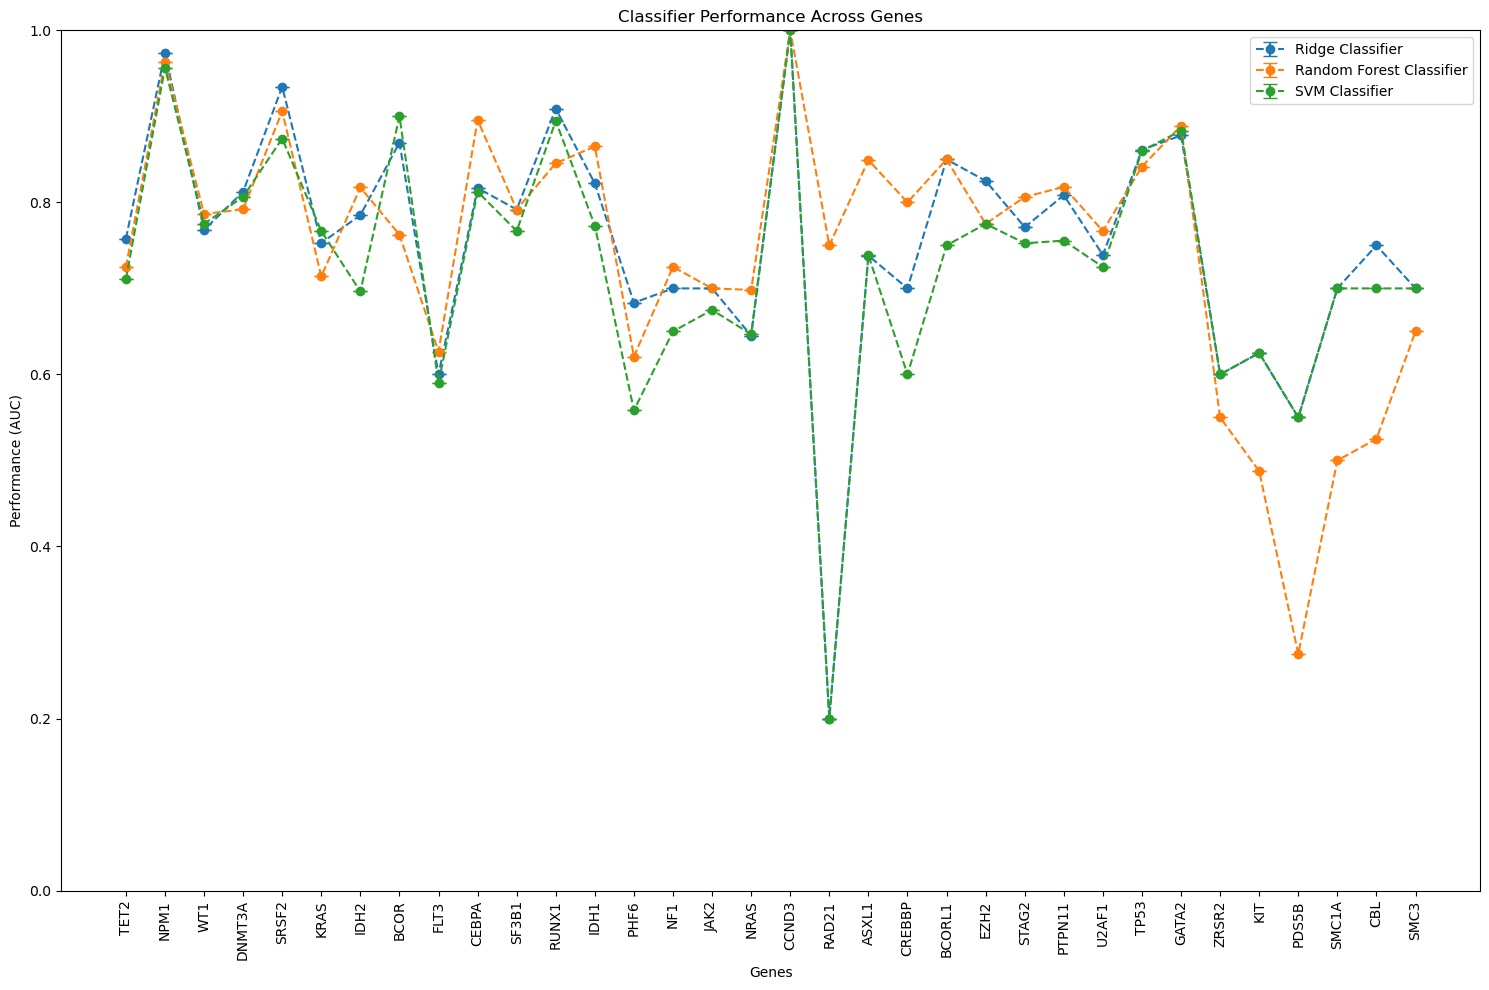

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming performance_dict is your dictionary with the classifier performances

# Extract unique classifier names
classifiers = list(next(iter(performance_dict.values())).keys())

# Prepare data for plotting
genes = list(performance_dict.keys())
x = np.arange(len(genes))  # Gene indices

# Initialize figure and axis
plt.figure(figsize=(15, 10))

# Plot performance for each classifier
for clf_name in classifiers:
    means = [np.mean(performance_dict[gene][clf_name]) for gene in genes]
    stds = [np.std(performance_dict[gene][clf_name]) for gene in genes]
    plt.errorbar(x, means, yerr=stds, label=clf_name, capsize=5, marker='o', linestyle='--')

# Customize the plot
plt.xticks(x, genes, rotation=90)
plt.xlabel('Genes')
plt.ylabel('Performance (AUC)')
plt.title('Classifier Performance Across Genes')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


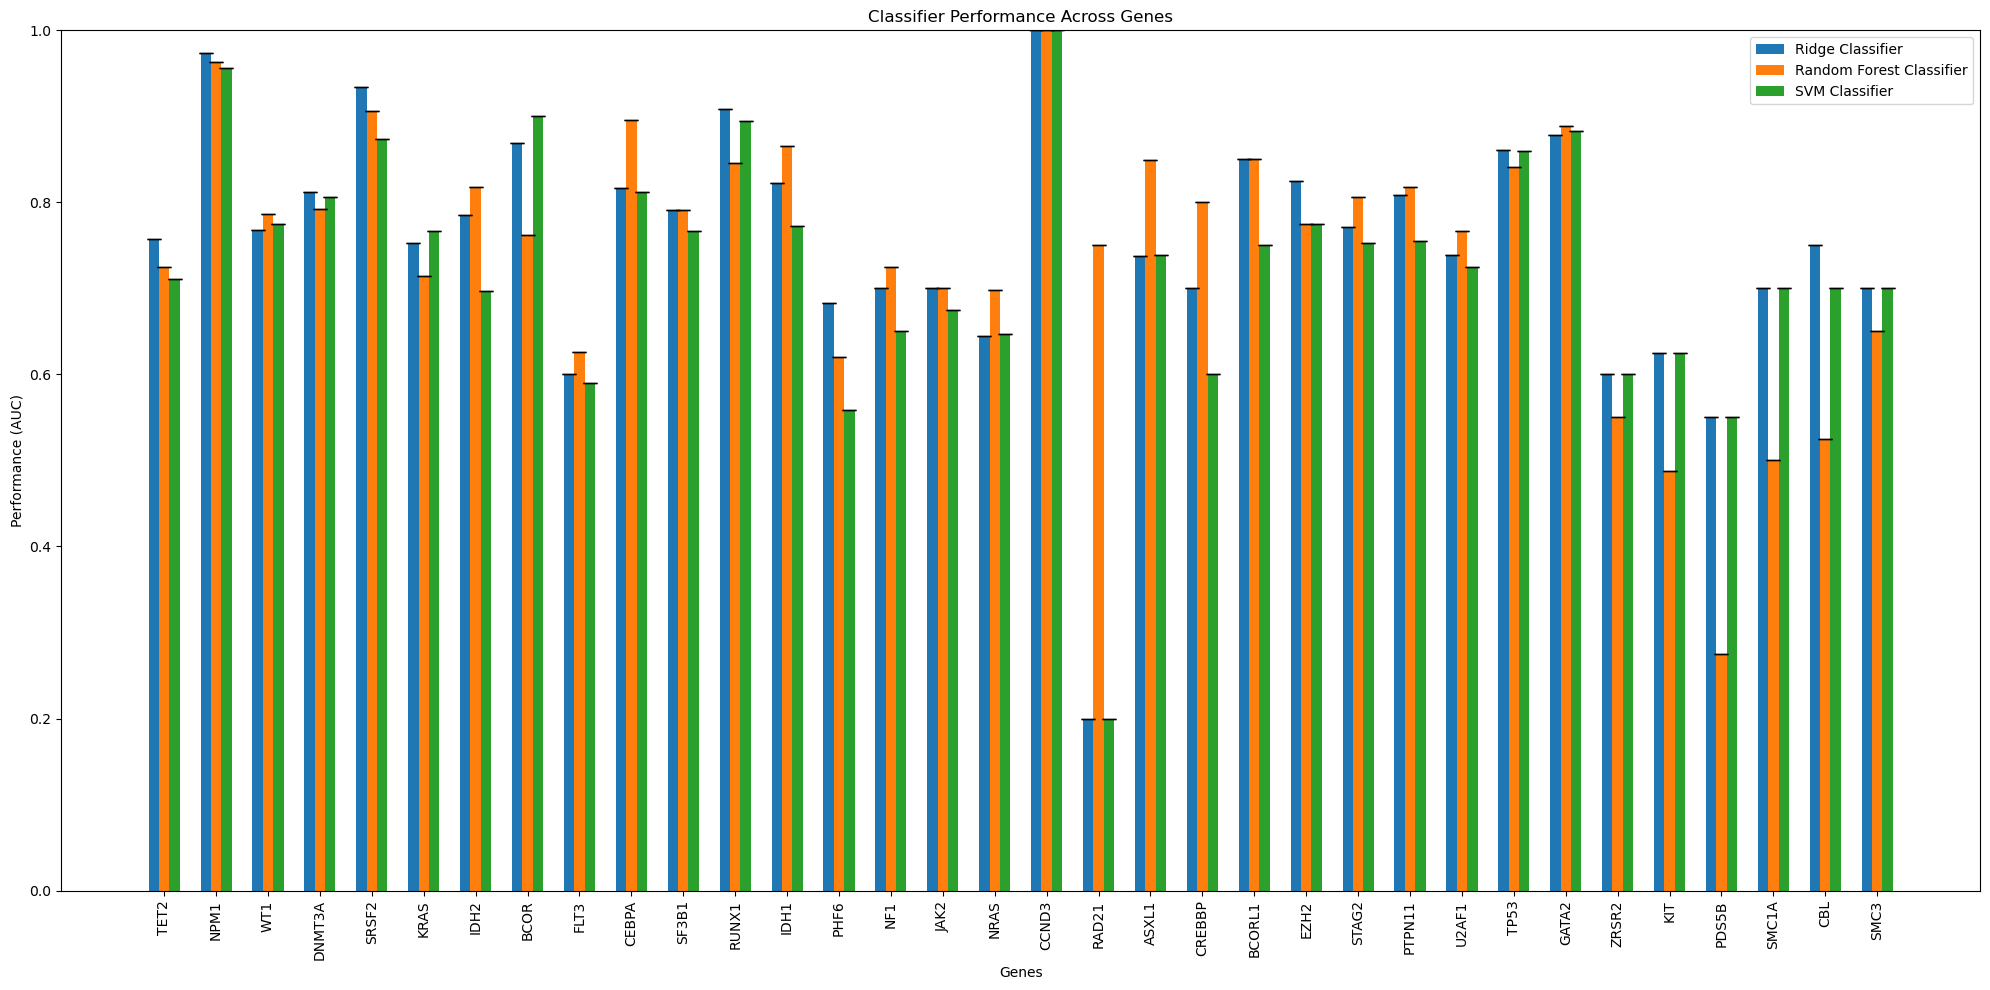

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming performance_dict is your dictionary with the classifier performances

# Extract unique classifier names
classifiers = list(next(iter(performance_dict.values())).keys())

# Prepare data for plotting
genes = list(performance_dict.keys())
x = np.arange(len(genes))  # Gene indices
width = 0.2  # Width of the bars

# Initialize figure and axis
plt.figure(figsize=(20, 10))

# Create a bar for each classifier
for i, clf_name in enumerate(classifiers):
    means = [np.mean(performance_dict[gene][clf_name]) for gene in genes]
    stds = [np.std(performance_dict[gene][clf_name]) for gene in genes]
    plt.bar(x + i*width, means, width, yerr=stds, label=clf_name, capsize=5)

# Customize the plot
plt.xticks(x + width, genes, rotation=90)
plt.xlabel('Genes')
plt.ylabel('Performance (AUC)')
plt.title('Classifier Performance Across Genes')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()



In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

mutation = 'DNMT3A'

# Assuming bulk RNA-seq data predictions and true labels are available
bulk_y_true = mut_data_agg[mutation].astype(int)
ridge_bulk_probs = predictions[f'ridge_bulk_probs_{mutation}']

# Separate the scores based on ground truth labels
positive_scores = ridge_bulk_probs[bulk_y_true == 1]
negative_scores = ridge_bulk_probs[bulk_y_true == 0]

# Create a DataFrame for easier plotting with seaborn
import pandas as pd

scores_df = pd.DataFrame({
    'Scores': np.concatenate([positive_scores, negative_scores]),
    'Class': ['Positive'] * len(positive_scores) + ['Negative'] * len(negative_scores)
})

# Plot the distribution of scores for positive and negative samples
plt.figure(figsize=(12, 8))
sns.histplot(data=scores_df, x='Scores', hue='Class', kde=True, element='step', stat='density', common_norm=False)
plt.title(f'Distribution of Scores for {mutation} Mutation in Bulk Data')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()


NameError: name 'predictions' is not defined

In [70]:
scRNA_data = adata[adata.obs['dataset'] == '0']
#scRNA_data = adata[adata.obs['batch'] == 'scRNA']

# NOTE: Using .X instead of .obsm['X_pca']
#X_scRNA_pca = scRNA_data.obsm['X_pca']
X_scRNA_pca = scRNA_data.X
#X_scRNA_pca_scaled = scaler.transform(X_scRNA_pca)
X_scRNA_pca_scaled = X_scRNA_pca


In [71]:
print(X_scRNA_pca_scaled)
print(X_scRNA_pca_scaled.shape)
print(X_scRNA_pca_scaled.min())
print(X_scRNA_pca_scaled.max())


[[-0.10191083 -0.06539354 -0.03399551 ... -0.21887918 -0.06656585
  -0.12278026]
 [-0.10191083 -0.06539354 -0.03399551 ... -0.21887918 -0.06656585
  -0.12278026]
 [-0.10191083 -0.06539354 -0.03399551 ...  3.430251   -0.06656585
  -0.12278026]
 ...
 [-0.10191083 -0.06539354 -0.03399551 ... -0.21887918 -0.06656585
  -0.12278026]
 [-0.10191083 -0.06539354 -0.03399551 ... -0.21887918 -0.06656585
  -0.12278026]
 [-0.10191083 -0.06539354 -0.03399551 ... -0.21887918 -0.06656585
  -0.12278026]]
(42668, 5070)
-4.673204
10.0


In [72]:
# Apply trained models to scRNA-seq data
print('Beginning to apply trained models to scRNA-seq data..')

# Dictionary to store prediction results
predictions = {}

print(valid_mutations)

# Apply predictions only for valid mutations
for mutation in valid_mutations:
    
    print(f'Predicting mutation status in single-cell data for mutation: {mutation}..')
    y_mutation = mut_data_agg[mutation].astype(int)
    
    # Train the final models
    ridge_model.fit(X_pca_scaled, y_mutation)
    rf_model.fit(X_pca_scaled, y_mutation)
    svm_model.fit(X_pca_scaled, y_mutation)
    
    # Predict using scRNA-seq data
    scRNA_data.obs[f'ridge_preds_{mutation}'] = ridge_model.predict(X_scRNA_pca_scaled)
    scRNA_data.obs[f'rf_preds_{mutation}'] = rf_model.predict(X_scRNA_pca_scaled)
    scRNA_data.obs[f'svm_preds_{mutation}'] = svm_model.predict(X_scRNA_pca_scaled)
    
    # Save predictions to dictionary
    predictions[f'ridge_preds_{mutation}'] = scRNA_data.obs[f'ridge_preds_{mutation}']
    predictions[f'rf_preds_{mutation}'] = scRNA_data.obs[f'rf_preds_{mutation}']
    predictions[f'svm_preds_{mutation}'] = scRNA_data.obs[f'svm_preds_{mutation}']

print("Models trained and predictions applied to scRNA-seq data.")    



Beginning to apply trained models to scRNA-seq data..
['TET2', 'NPM1', 'WT1', 'DNMT3A', 'SRSF2', 'KRAS', 'IDH2', 'BCOR', 'FLT3', 'CEBPA', 'SF3B1', 'RUNX1', 'IDH1', 'PHF6', 'NF1', 'JAK2', 'NRAS', 'CCND3', 'RAD21', 'ASXL1', 'CREBBP', 'BCORL1', 'EZH2', 'STAG2', 'PTPN11', 'U2AF1', 'TP53', 'GATA2', 'ZRSR2', 'KIT', 'PDS5B', 'SMC1A', 'CBL', 'SMC3']
Predicting mutation status in single-cell data for mutation: TET2..


/tmp/ipykernel_1456/3489598514.py:21: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scRNA_data.obs[f'ridge_preds_{mutation}'] = ridge_model.predict(X_scRNA_pca_scaled)


Predicting mutation status in single-cell data for mutation: NPM1..
Predicting mutation status in single-cell data for mutation: WT1..
Predicting mutation status in single-cell data for mutation: DNMT3A..
Predicting mutation status in single-cell data for mutation: SRSF2..
Predicting mutation status in single-cell data for mutation: KRAS..
Predicting mutation status in single-cell data for mutation: IDH2..
Predicting mutation status in single-cell data for mutation: BCOR..
Predicting mutation status in single-cell data for mutation: FLT3..
Predicting mutation status in single-cell data for mutation: CEBPA..
Predicting mutation status in single-cell data for mutation: SF3B1..
Predicting mutation status in single-cell data for mutation: RUNX1..
Predicting mutation status in single-cell data for mutation: IDH1..
Predicting mutation status in single-cell data for mutation: PHF6..
Predicting mutation status in single-cell data for mutation: NF1..
Predicting mutation status in single-cell da

/tmp/ipykernel_1456/3489598514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'svm_preds_{mutation}'] = svm_model.predict(X_scRNA_pca_scaled)


Predicting mutation status in single-cell data for mutation: SMC3..


/tmp/ipykernel_1456/3489598514.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ridge_preds_{mutation}'] = ridge_model.predict(X_scRNA_pca_scaled)
/tmp/ipykernel_1456/3489598514.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'rf_preds_{mutation}'] = rf_model.predict(X_scRNA_pca_scaled)


Models trained and predictions applied to scRNA-seq data.


/tmp/ipykernel_1456/3489598514.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'svm_preds_{mutation}'] = svm_model.predict(X_scRNA_pca_scaled)


In [73]:
# Write the ROC AUC dictionary to a csv file
import csv

# Flatten the dictionary structure
flattened_data = []
for key, subdict in roc_auc_dict.items():
    for subkey, value_list in subdict.items():
        flattened_data.append([key, subkey] + value_list)

# Specify the CSV file name
csv_file = '/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/roc_auc_dict_to_file.csv'

# Write the flattened data to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header
    max_list_length = max(len(lst) for subdict in roc_auc_dict.values() for lst in subdict.values())
    header = ['key', 'subkey'] + [f'value_{i+1}' for i in range(max_list_length)]
    writer.writerow(header)
    
    # Write the rows
    writer.writerows(flattened_data)

print(f"ROC AUC dict data has been written to {csv_file}")



ROC AUC dict data has been written to /home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/roc_auc_dict_to_file.csv


In [74]:
# Convert dictionary to DataFrame and save to CSV
predictions_df = pd.DataFrame(predictions, index=scRNA_data.obs_names)
predictions_df.to_csv('/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/1000_gene_features_X_mutation_predictions_256gb_memory_run.csv')

# Save the updated AnnData object
scRNA_data.write('/home/groups/precepts/ashforda/scOPE_github_stuff/trained_models/1000_gene_features_adata_with_predictions_256gb_memory_run.h5ad')


In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Modules for new models
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Original models
'''
# Initialize your models
#ridge_model = RidgeClassifier()  # Note: RidgeClassifier does not have predict_proba
#rf_model = RandomForestClassifier()
#svm_model = SVC(probability=True)  # Make sure SVM is configured to output probabilities
'''
# Model training with hyperparameter tuning and calibration
ridge_model = CalibratedClassifierCV(RidgeClassifierCV(), method='sigmoid')
rf_model = GridSearchCV(RandomForestClassifier(), param_grid={'n_estimators': [100, 200], 'max_depth': [5, 10]}, cv=5)
svm_model = CalibratedClassifierCV(SVC(probability=True), method='sigmoid')
gbm_model = GridSearchCV(GradientBoostingClassifier(), param_grid={'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}, cv=5)

# Apply trained models to scRNA-seq data
print('Beginning to apply trained models to scRNA-seq data..')

# Dictionary to store prediction results
predictions = {}

print(valid_mutations)

# Apply predictions only for valid mutations
for mutation in valid_mutations:
    print(f'Predicting mutation status in single-cell data for mutation: {mutation}..')
    y_mutation = mut_data_agg[mutation].astype(int)
    
    # Train the final models on bulk RNA-seq data
    ridge_model.fit(X_pca_scaled, y_mutation)
    rf_model.fit(X_pca_scaled, y_mutation)
    svm_model.fit(X_pca_scaled, y_mutation)
    gbm_model.fit(X_pca_scaled, y_mutation)
    
    '''
    # Predict using scRNA-seq data
    # RidgeClassifier does not have predict_proba, using decision_function instead
    ridge_probs = ridge_model.decision_function(X_scRNA_pca_scaled)
    rf_probs = rf_model.predict_proba(X_scRNA_pca_scaled)[:, 1]
    svm_probs = svm_model.predict_proba(X_scRNA_pca_scaled)[:, 1]
    '''
    # Predict using scRNA-seq data
    ridge_probs = ridge_model.predict_proba(X_scRNA_pca_scaled)[:, 1]
    rf_probs = rf_model.predict_proba(X_scRNA_pca_scaled)[:, 1]
    svm_probs = svm_model.predict_proba(X_scRNA_pca_scaled)[:, 1]
    gbm_probs = gbm_model.predict_proba(X_scRNA_pca_scaled)[:, 1]
    
    # Combine predictions using an ensemble method (e.g., average)
    ensemble_probs = (ridge_probs + rf_probs + svm_probs + gbm_probs) / 4
    
    scRNA_data.obs[f'ridge_preds_{mutation}'] = ridge_probs
    scRNA_data.obs[f'rf_preds_{mutation}'] = rf_probs
    scRNA_data.obs[f'svm_preds_{mutation}'] = svm_probs
    # New preds
    scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
    scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs
    
    # Save predictions to dictionary
    predictions[f'ridge_preds_{mutation}'] = ridge_probs
    predictions[f'rf_preds_{mutation}'] = rf_probs
    predictions[f'svm_preds_{mutation}'] = svm_probs
    # New preds
    predictions[f'gbm_preds_{mutation}'] = gbm_probs
    predictions[f'ensemble_preds_{mutation}'] = ensemble_probs

    '''
    # Additionally, save the predicted probabilities for the bulk RNA-seq data
    ridge_bulk_probs = ridge_model.decision_function(X_pca_scaled)
    rf_bulk_probs = rf_model.predict_proba(X_pca_scaled)[:, 1]
    svm_bulk_probs = svm_model.predict_proba(X_pca_scaled)[:, 1]
    '''
    ridge_bulk_probs = ridge_model.predict_proba(X_pca_scaled)[:, 1]
    rf_bulk_probs = rf_model.predict_proba(X_pca_scaled)[:, 1]
    svm_bulk_probs = svm_model.predict_proba(X_pca_scaled)[:, 1]
    
    predictions[f'ridge_bulk_probs_{mutation}'] = ridge_bulk_probs
    predictions[f'rf_bulk_probs_{mutation}'] = rf_bulk_probs
    predictions[f'svm_bulk_probs_{mutation}'] = svm_bulk_probs

print("Models trained and predictions applied to scRNA-seq data.")


Beginning to apply trained models to scRNA-seq data..
['TET2', 'NPM1', 'WT1', 'DNMT3A', 'SRSF2', 'KRAS', 'IDH2', 'BCOR', 'FLT3', 'CEBPA', 'SF3B1', 'RUNX1', 'IDH1', 'PHF6', 'NF1', 'JAK2', 'NRAS', 'CCND3', 'RAD21', 'ASXL1', 'CREBBP', 'BCORL1', 'EZH2', 'STAG2', 'PTPN11', 'U2AF1', 'TP53', 'GATA2', 'ZRSR2', 'KIT', 'PDS5B', 'SMC1A', 'CBL', 'SMC3']
Predicting mutation status in single-cell data for mutation: TET2..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: NPM1..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: WT1..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: DNMT3A..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: SRSF2..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: KRAS..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: IDH2..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: BCOR..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: FLT3..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: CEBPA..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: SF3B1..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: RUNX1..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: IDH1..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: PHF6..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: NF1..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: JAK2..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: NRAS..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: CCND3..


/tmp/ipykernel_1456/2899793747.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'gbm_preds_{mutation}'] = gbm_probs
/tmp/ipykernel_1456/2899793747.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs[f'ensemble_preds_{mutation}'] = ensemble_probs


Predicting mutation status in single-cell data for mutation: RAD21..


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
import numpy as np

def permutation_test_auc(bulk_y_true, bulk_probs, n_permutations=1000):
    # Calculate the observed AUC using the bulk RNA-seq data
    observed_auc = roc_auc_score(bulk_y_true, bulk_probs)
    
    # Generate the null distribution by permuting the labels
    permuted_aucs = np.zeros(n_permutations)
    for i in range(n_permutations):
        permuted_labels = shuffle(bulk_y_true)
        permuted_aucs[i] = roc_auc_score(permuted_labels, bulk_probs)
    
    # Calculate the p-value
    p_value = (np.sum(permuted_aucs >= observed_auc) + 1) / (n_permutations + 1)
    
    return observed_auc, p_value



In [ ]:
#mutation = 'TP53'
#mutation = 'FLT3'
mutation = 'NPM1'
#mutation = 'NRAS'

bulk_y_true = mut_data_agg[mutation].astype(int)
ridge_bulk_probs = predictions[f'ridge_bulk_probs_{mutation}']

# Check the shapes
print("Shape of bulk_y_true:", bulk_y_true.shape)
print("Shape of ridge_bulk_probs:", ridge_bulk_probs.shape)

# Calculate AUC and p-value
observed_auc, p_value = permutation_test_auc(bulk_y_true, ridge_bulk_probs)
print(f"Observed AUC for {mutation}: {observed_auc}")
print(f"P-value: {p_value}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

# Function to perform permutation test and get null distribution
def permutation_test_auc(bulk_y_true, bulk_probs, n_permutations=1000):
    observed_auc = roc_auc_score(bulk_y_true, bulk_probs)
    permuted_aucs = np.zeros(n_permutations)
    
    for i in range(n_permutations):
        permuted_labels = shuffle(bulk_y_true)
        permuted_aucs[i] = roc_auc_score(permuted_labels, bulk_probs)
    
    p_value = (np.sum(permuted_aucs >= observed_auc) + 1) / (n_permutations + 1)
    
    return observed_auc, p_value, permuted_aucs



In [ ]:
bulk_y_true = mut_data_agg[mutation].astype(int)
ridge_bulk_probs = predictions[f'ridge_bulk_probs_{mutation}']

# Calculate AUC and p-value
observed_auc, p_value, permuted_aucs = permutation_test_auc(bulk_y_true, ridge_bulk_probs)

# Plot ROC curve
fpr, tpr, _ = roc_curve(bulk_y_true, ridge_bulk_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))

# ROC curve plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for TET2 Mutation')
plt.legend(loc="lower right")

# Null distribution plot
plt.subplot(1, 2, 2)
sns.histplot(permuted_aucs, bins=30, kde=True)
plt.axvline(observed_auc, color='red', linestyle='--', label=f'Observed AUC: {observed_auc:.2f}')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.title('Null Distribution of AUCs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
print(p_value)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming bulk RNA-seq data predictions and true labels are available
bulk_y_true = mut_data_agg[mutation].astype(int)
ridge_bulk_probs = predictions[f'ridge_bulk_probs_{mutation}']

# Separate the scores based on ground truth labels
positive_scores = ridge_bulk_probs[bulk_y_true == 1]
negative_scores = ridge_bulk_probs[bulk_y_true == 0]

# Create a DataFrame for easier plotting with seaborn
import pandas as pd

scores_df = pd.DataFrame({
    'Scores': np.concatenate([positive_scores, negative_scores]),
    'Class': ['Positive'] * len(positive_scores) + ['Negative'] * len(negative_scores)
})

# Plot the distribution of scores for positive and negative samples
plt.figure(figsize=(12, 8))
sns.histplot(data=scores_df, x='Scores', hue='Class', kde=True, element='step', stat='density', common_norm=False)
plt.title(f'Distribution of Scores for {mutation} Mutation in Bulk Data')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()


In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Check the shape and content of the data
#print("Shape of X_scRNA_pca_scaled:", X_scRNA_pca_scaled.shape)
#print("Head of X_scRNA_pca_scaled:\n", pd.DataFrame(X_scRNA_pca_scaled).head())

# Perform UMAP dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embedding = reducer.fit_transform(X_scRNA_pca_scaled)

# Ensure the UMAP embedding is created correctly
print("Shape of UMAP embedding:", umap_embedding.shape)

# Assuming scRNA_data is an AnnData object and predictions are stored in its obs
predicted_status = scRNA_data.obs[f'ridge_preds_{mutation}']

# Check the predicted status data
print("Predicted status unique values:", predicted_status.unique())

# Create a DataFrame for plotting
umap_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
umap_df['predicted_status'] = predicted_status.values

# Ensure the DataFrame is created correctly
print("Head of UMAP DataFrame:\n", umap_df.head())

# Plot UMAP
plt.figure(figsize=(10, 8))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='predicted_status', palette='viridis', s=5)
plt.title(f'UMAP of Single-Cell Transcriptomes for {mutation} Mutation')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Predicted Status')
plt.show()



In [ ]:
print(min(scRNA_data.obs[f'ensemble_preds_{mutation}']))
print(max(scRNA_data.obs[f'ensemble_preds_{mutation}']))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the predicted probabilities for single-cell RNA-seq data
sc_preds = scRNA_data.obs[f'ensemble_preds_{mutation}']

# Plot the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(sc_preds, kde=True)
plt.title(f'Distribution of Predicted Probabilities for {mutation} Mutation')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.show()



In [ ]:
print(valid_mutations)


/tmp/ipykernel_31473/1952036648.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pca_df, x='Predicted Status', y=pc, palette='muted')


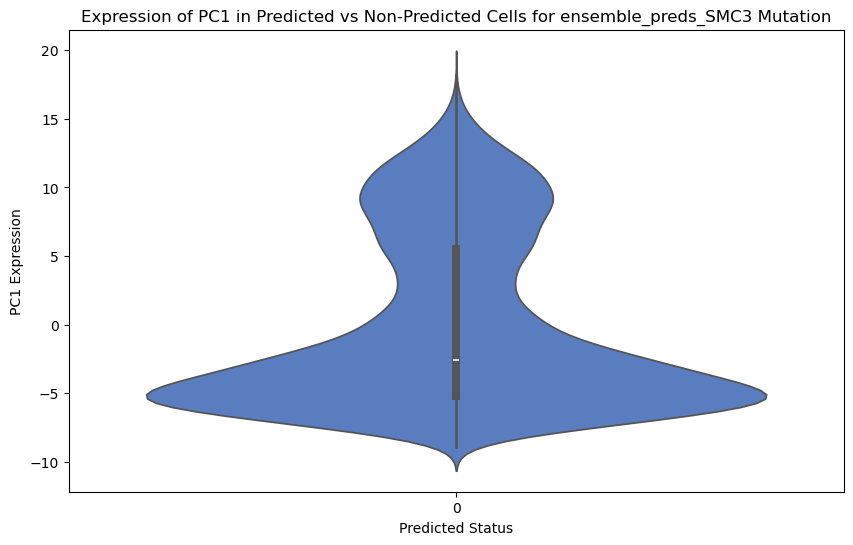

/tmp/ipykernel_31473/1952036648.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pca_df, x='Predicted Status', y=pc, palette='muted')


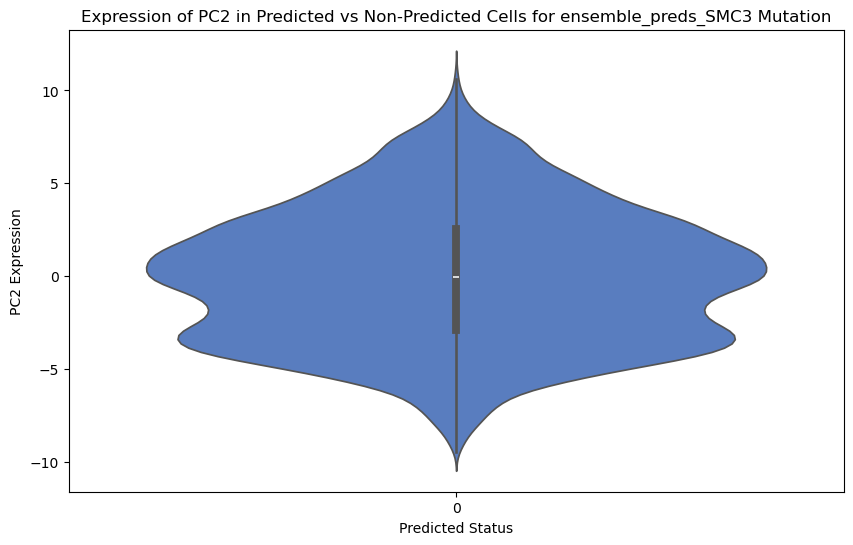

/tmp/ipykernel_31473/1952036648.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pca_df, x='Predicted Status', y=pc, palette='muted')


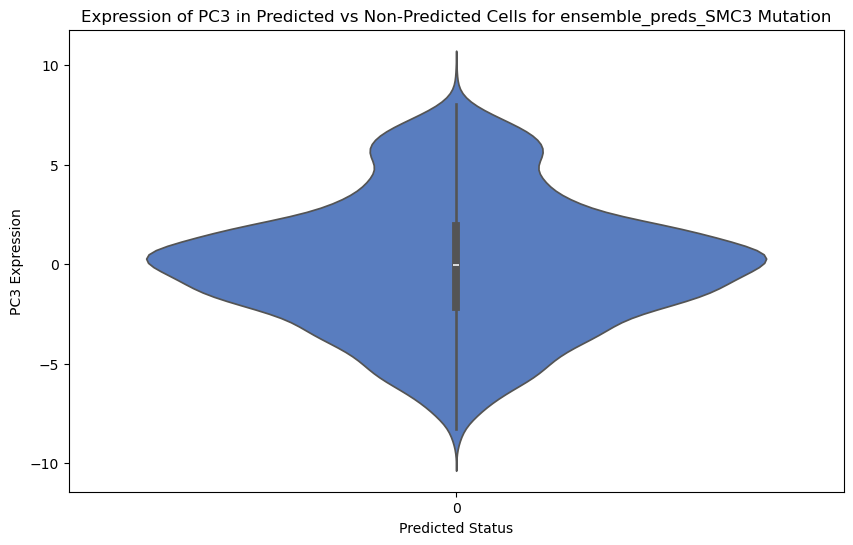

/tmp/ipykernel_31473/1952036648.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pca_df, x='Predicted Status', y=pc, palette='muted')


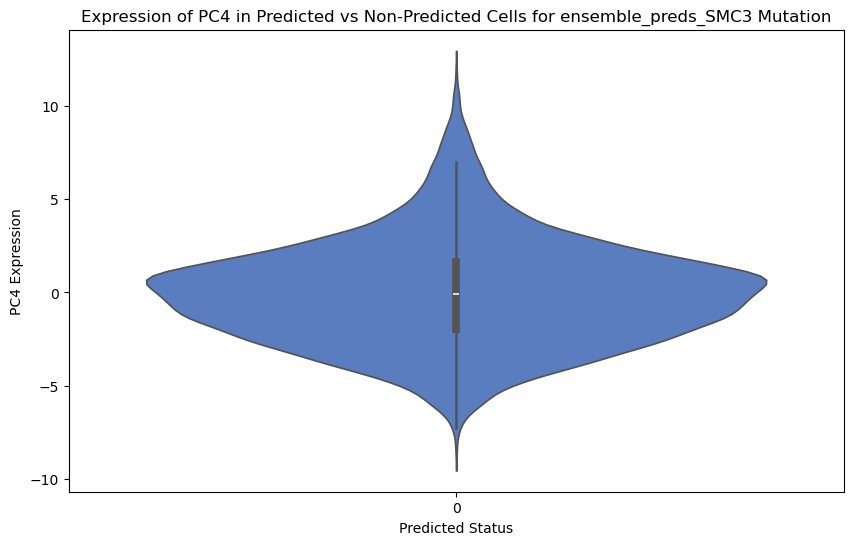

/tmp/ipykernel_31473/1952036648.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pca_df, x='Predicted Status', y=pc, palette='muted')


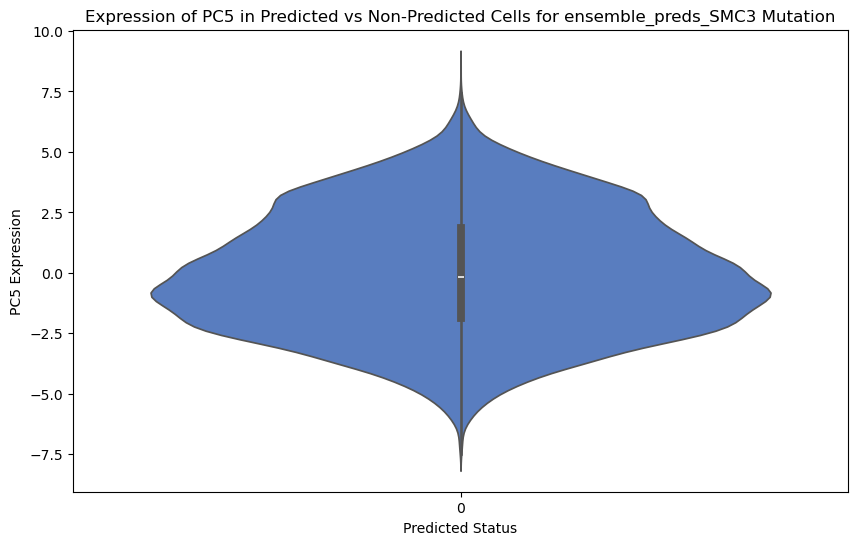

/tmp/ipykernel_31473/1952036648.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pca_df, x='Predicted Status', y=pc, palette='muted')


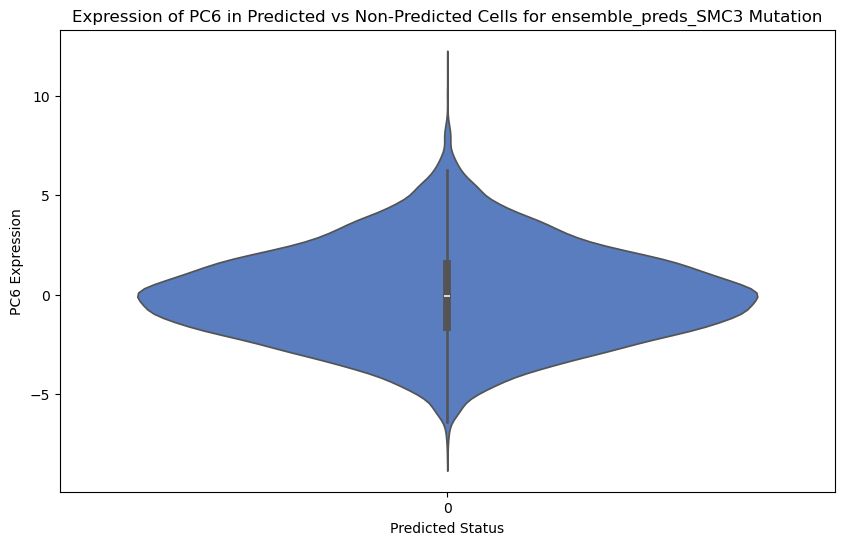

/tmp/ipykernel_31473/1952036648.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pca_df, x='Predicted Status', y=pc, palette='muted')


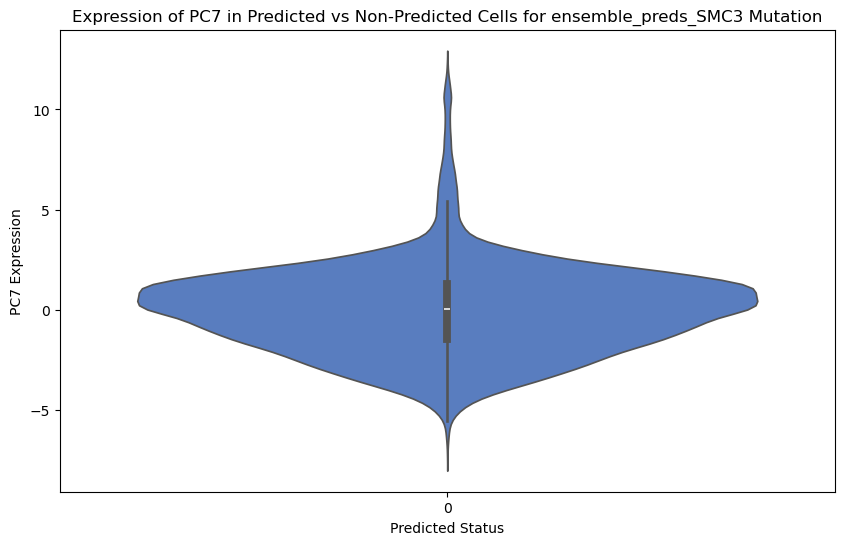

/tmp/ipykernel_31473/1952036648.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pca_df, x='Predicted Status', y=pc, palette='muted')


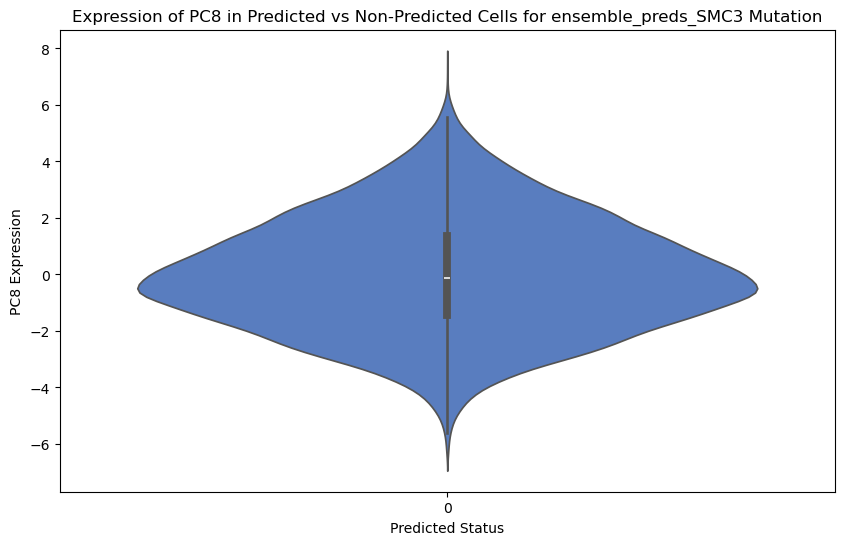

/tmp/ipykernel_31473/1952036648.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pca_df, x='Predicted Status', y=pc, palette='muted')


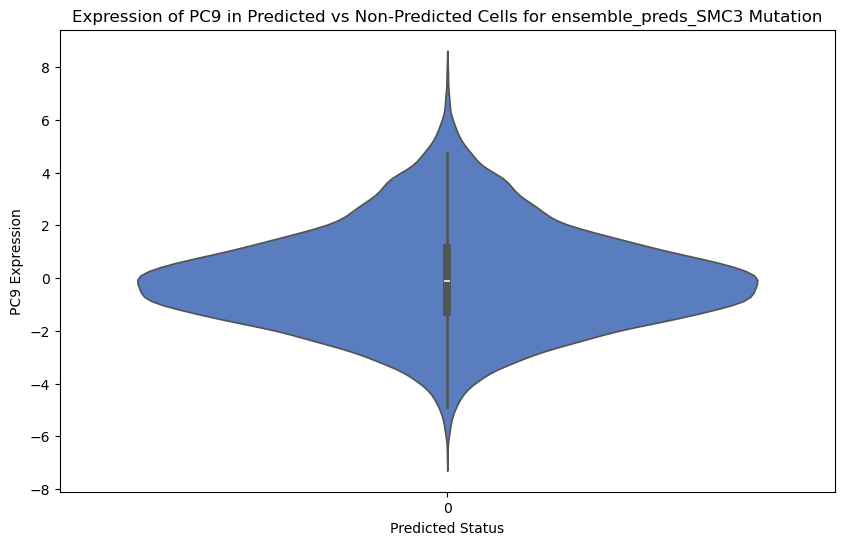

/tmp/ipykernel_31473/1952036648.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pca_df, x='Predicted Status', y=pc, palette='muted')


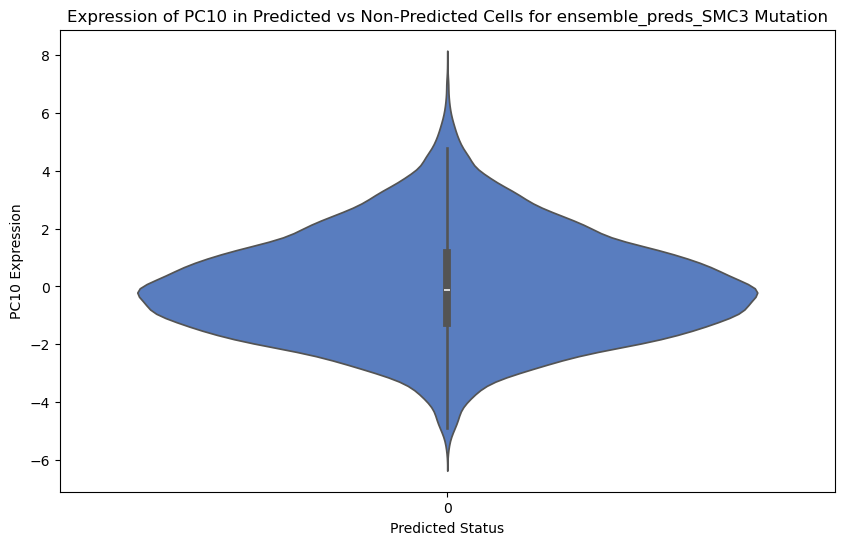

In [609]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# Assuming scRNA_data is an AnnData object and you have the top variable genes in scRNA_data.var_names

# Extract the gene expression data (X) and convert it to a dense matrix if needed
gene_expression_data = scRNA_data.X

# Perform PCA to reduce dimensionality
pca = PCA(n_components=10)  # You can choose the number of components
pca_result = pca.fit_transform(gene_expression_data)

# Extract predicted mutation status probabilities
#predicted_probs = scRNA_data.obs[f'ensemble_preds_{mutation}']
predicted_probs = scRNA_data.obs[f'{mutation}']

# Define a threshold to binarize the predicted probabilities into predicted status
threshold = 0.9  # Adjust threshold based on your model's characteristics
predicted_status = (predicted_probs >= threshold).astype(int)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df['Predicted Status'] = predicted_status.values

# Plot Violin Plots for each principal component
for pc in pca_df.columns[:-1]:  # Exclude the 'Predicted Status' column
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=pca_df, x='Predicted Status', y=pc, palette='muted')
    plt.title(f'Expression of {pc} in Predicted vs Non-Predicted Cells for {mutation} Mutation')
    plt.xlabel('Predicted Status')
    plt.ylabel(f'{pc} Expression')
    plt.show()
    


/home/groups/precepts/ashforda/anaconda3/envs/scOPE_working_environment/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_31473/380981954.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)


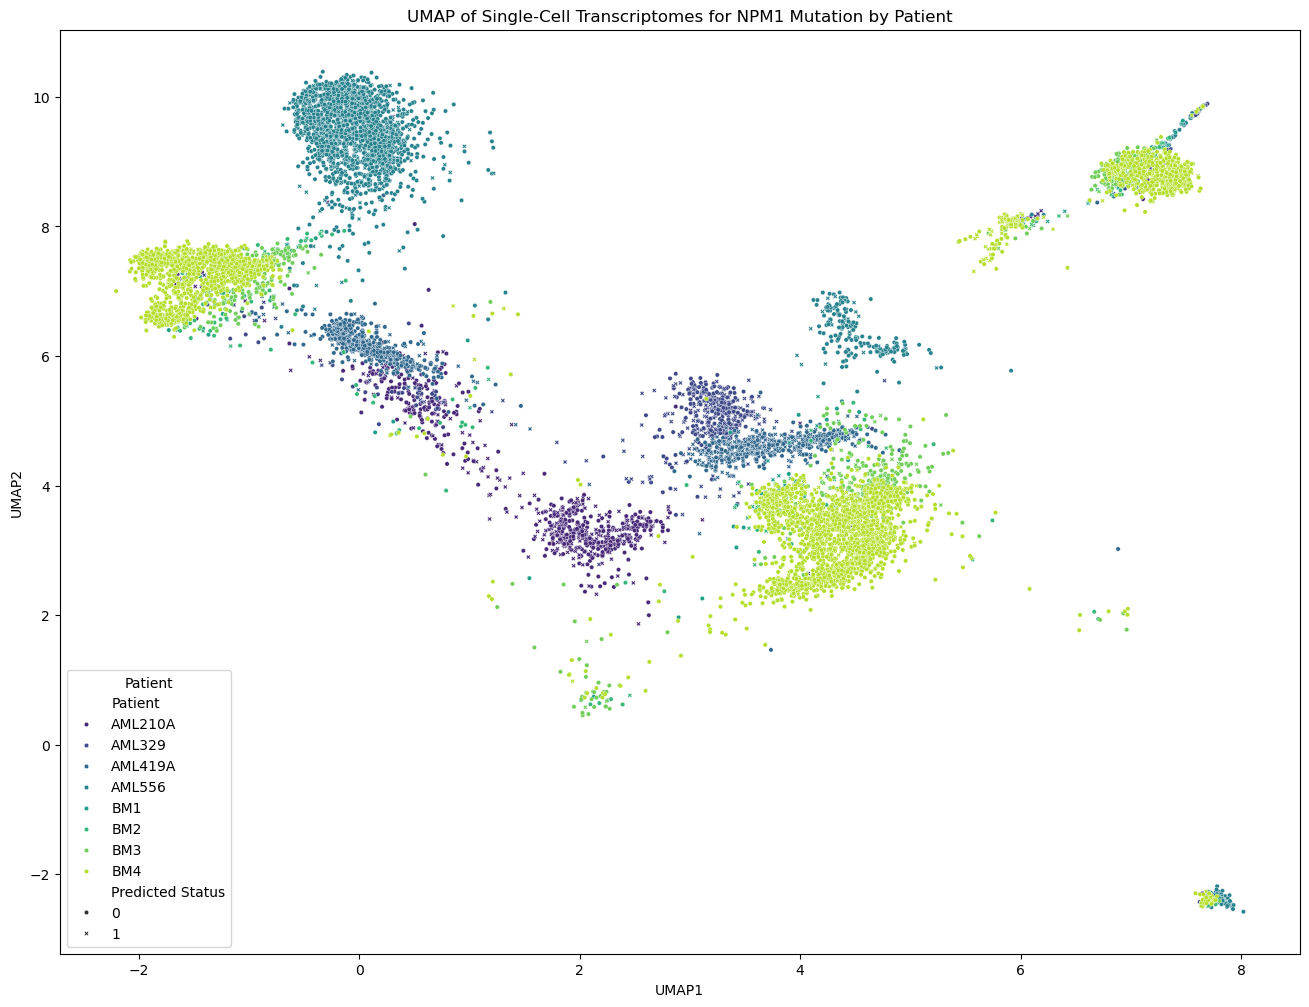

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import umap
import re


# Extract the gene expression data (X) and convert it to a dense matrix if needed
gene_expression_data = scRNA_data.X

# Perform UMAP to reduce dimensionality
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(gene_expression_data)

# Extract predicted mutation status probabilities
predicted_probs = scRNA_data.obs[f'ridge_preds_{mutation}']

# Convert raw scores to probabilities if necessary
if predicted_probs.min() < 0 or predicted_probs.max() > 1:
    predicted_probs = 1 / (1 + np.exp(-predicted_probs))

# Define a threshold to binarize the predicted probabilities into predicted status
threshold = 0.90  # Adjust threshold based on your model's characteristics
predicted_status = (predicted_probs >= threshold).astype(int)

# Extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Select patients to highlight
#selected_patients = ['AML1012', 'AML210A', 'AML419A', 'AML916', 'AML921A', 'AML314', 'AML371', 'AML475', 'AML722B', 'AML870', 'AML997', 'AML329', 'AML420B', 'AML556', 'AML328', 'AML707B', 'AML419A', 'AML328', 'AML707B', 'BM1', 'BM2', 'BM3', 'BM4']  # Example patients, replace with your selections
selected_patients = ['AML210A', 'AML419A', 'AML996', 'AML329', 'AML556', 'BM1', 'BM2', 'BM3', 'BM4']

# Create a DataFrame for plotting
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['Predicted Status'] = predicted_status.values
umap_df['Patient'] = scRNA_data.obs['Patient'].values

# Filter DataFrame to include only selected patients if necessary
filtered_umap_df = umap_df[umap_df['Patient'].isin(selected_patients)]

# Plot UMAP scatter plot
plt.figure(figsize=(16, 12))
sns.scatterplot(data=filtered_umap_df, x='UMAP1', y='UMAP2', hue='Patient', style='Predicted Status', palette='viridis', s=10)
plt.title(f'UMAP of Single-Cell Transcriptomes for {mutation} Mutation by Patient')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Patient')
plt.show()



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# User specifies the patient and mutation to analyze
specific_patient = 'AML556'  # Replace with the patient ID you want to analyze
specific_mutation = 'NPM1'   # Replace with the mutation you want to analyze
healthy_sample = 'BM4'       # Replace with the healthy sample ID you want to include

# Function to extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Extract predicted mutation status probabilities for the specific mutation
predicted_probs = scRNA_data.obs[f'ensemble_preds_{specific_mutation}']

# Convert raw scores to probabilities if necessary
#if predicted_probs.min() < 0 or predicted_probs.max() > 1:
#    predicted_probs = 1 / (1 + np.exp(-predicted_probs))

# Filter for the specific patient and healthy sample
patient_scores = predicted_probs[scRNA_data.obs['Patient'] == specific_patient]
healthy_scores = predicted_probs[scRNA_data.obs['Patient'] == healthy_sample]

# Create a DataFrame for easier plotting with seaborn
scores_df = pd.DataFrame({
    'Scores': np.concatenate([patient_scores, healthy_scores]),
    'Sample': ['Patient'] * len(patient_scores) + ['Healthy'] * len(healthy_scores)
})

# Plot the distribution of scores for the specified mutation in the specific patient and healthy sample
plt.figure(figsize=(14, 10))

# Plot each sample type separately to ensure labels are included
sns.histplot(data=scores_df[scores_df['Sample'] == 'Patient'], x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=25, label='Patient ' + specific_patient)
sns.histplot(data=scores_df[scores_df['Sample'] == 'Healthy'], x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=25, label='Healthy sample ' + healthy_sample)

# Manually add the legend
plt.legend(title='Sample')

plt.title(f'Distribution of Predicted Scores for {specific_mutation} Mutation in Patient {specific_patient} and Healthy Sample {healthy_sample}')
plt.xlabel('Score')
plt.ylabel('Proportion')
plt.show()


In [ ]:
# Create a Series with patient names
patient_names = scRNA_data.obs['Patient'].apply(lambda x: x.split('_')[0] if '_' in x else x.split('-')[0])

# Print all unique patient names
unique_patient_names = patient_names.unique()
print(unique_patient_names)


In [ ]:
print(scRNA_data.obs['Patient'])


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

def plot_patient_vs_healthy(scRNA_data, specific_patient, specific_mutation):
    # Function to extract patient information from observation indices
    def extract_patient_id(index):
        match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
        return match.group(0) if match else 'Unknown'

    scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

    # Extract predicted mutation status probabilities for the specific mutation
    #predicted_probs = scRNA_data.obs[f'ridge_preds_{specific_mutation}']
    predicted_probs = scRNA_data.obs[f'ensemble_preds_{specific_mutation}']

    # Filter for the specific patient and all healthy samples
    #patient_scores = predicted_probs[scRNA_data.obs['Patient'] == specific_patient]
    #patient_scores = predicted_probs[scRNA_data.obs['Patient'].str.startswith(specific_patient)]
    patient_scores = predicted_probs[scRNA_data.obs_names.str.startswith(specific_patient)]
    healthy_scores = predicted_probs[scRNA_data.obs['Patient'].str.startswith('BM')]

    # Create a DataFrame for easier plotting with seaborn
    scores_df = pd.DataFrame({
        'Scores': np.concatenate([patient_scores, healthy_scores]),
        'Sample': ['Patient'] * len(patient_scores) + ['Healthy'] * len(healthy_scores)
    })

    # Plot the distribution of scores for the specified mutation in the specific patient and healthy samples
    plt.figure(figsize=(14, 10))

    # Plot each sample type separately to ensure labels are included
    sns.histplot(data=scores_df[scores_df['Sample'] == 'Patient'], x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label='Patient ' + specific_patient)
    sns.histplot(data=scores_df[scores_df['Sample'] == 'Healthy'], x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label='Healthy samples')
    #sns.histplot(data=scores_df[scores_df['Sample'] == 'Patient'], x='Scores', kde=True, element='step', stat='count', common_norm=False, bins=100, label='Patient ' + specific_patient)
    #sns.histplot(data=scores_df[scores_df['Sample'] == 'Healthy'], x='Scores', kde=True, element='step', stat='count', common_norm=False, bins=100, label='Healthy samples')

    # Manually add the legend
    plt.legend(title='Sample')

    plt.title(f'Distribution of Predicted Scores for {specific_mutation} Mutation in Patient {specific_patient} and 4 Healthy Samples')
    plt.xlabel('Score')
    plt.ylabel('Proportion')
    #plt.ylabel('Count')
    plt.show()

# Example usage
# NOTE: Patient AML556 has a .D0, .D15, and .D31
specific_patient = 'AML1012'
#specific_patient = 'AML556.D0'  # Replace with the patient ID you want to analyze
#specific_patient = 'AML556.D15'
#specific_patient = 'AML556.D31'
#specific_patient = 'AML328'
#specific_patient = 'AML328.D0'
#specific_patient = 'AML328.D29'
#specific_patient = 'AML328.D113'
#specific_patient = 'AML328.D171'
#specific_patient = 'AML916'
#specific_patient = 'AML419A'
#specific_patient = 'AML475'
#specific_patient = 'AML1012'
#specific_patient = 'AML556'
#specific_patient = 'AML328'
#specific_patient = 'AML707B'
#specific_patient = 'AML707B.D0'
#specific_patient = 'AML707B.D18'
#specific_patient = 'AML707B.D41'
#specific_patient = 'AML707B.D97'
#specific_patient = 'AML707B.D113'
#specific_patient = 'AML921A'
#specific_patient = 'AML210A'
#specific_patient = 'AML722B'
#specific_patient = 'AML870.D0'
#specific_patient = 'AML870.D14'
#specific_patient = 'AML997.D0'
#specific_patient = 'AML329.D0'
#specific_patient = 'AML329.D20'
#specific_patient = 'AML329.D37'
#specific_patient = 'AML420B.D0'
#specific_patient = 'OCI'
#specific_patient = 'MUTZ'

#specific_mutation = 'DNMT3A'   # Replace with the mutation you want to analyze
#specific_mutation = 'NPM1'
specific_mutation = 'NRAS'
#specific_mutation = 'KRAS'
#specific_mutation = 'TET2'
#specific_mutation = 'FLT3'
#specific_mutation = 'TP53'
#specific_mutation = 'KIT'
#specific_mutation = 'RAD21'
#specific_mutation = 'BRCC3'
#specific_mutation = 'RUNX1'
#specific_mutation = 'CEBPA'
#specific_mutation = 'BCORL1'
#specific_mutation = 'IDH2'
#specific_mutation = 'ASXL1'
#specific_mutation = 'PTPN11'
#specific_mutation = 'ZRSR2'
#specific_mutation = 'SMC3'
#specific_mutation = 'STAG2'
#specific_mutation = 'PHF6'
#specific_mutation = 'SF3B1'
#specific_mutation = 'GATA2'

plot_patient_vs_healthy(scRNA_data, specific_patient, specific_mutation)



/tmp/ipykernel_31473/2333171053.py:23: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = patient_data.concatenate(healthy_data)
/home/groups/precepts/ashforda/anaconda3/envs/scOPE_working_environment/lib/python3.12/site-packages/anndata/_core/merge.py:1286: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_annot[label] = label_col
/home/groups/precepts/ashforda/anaconda3/envs/scOPE_working_environment/lib/python3.12/site-packages/anndata/_core/merge.py:1286: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` 

<Figure size 1400x1000 with 0 Axes>

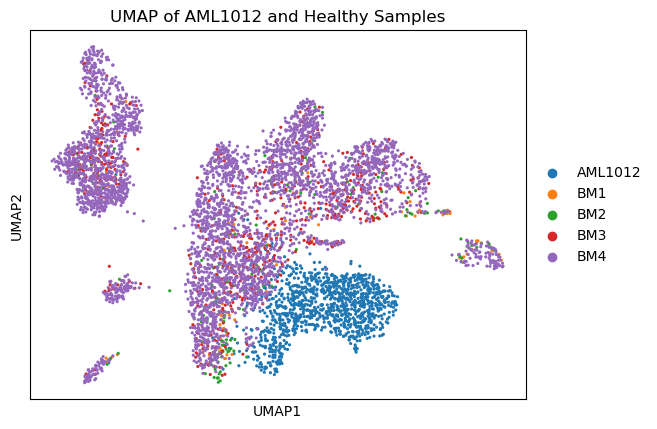

In [376]:
# Plot UMAP for AML patient versus normal samples
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import umap
import scanpy as sc

def plot_umap_patient_vs_healthy(scRNA_data, specific_patient):
    # Function to extract patient information from observation indices
    def extract_patient_id(index):
        match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
        return match.group(0) if match else 'Unknown'

    scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

    # Filter for the specific patient and all healthy samples
    patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]
    healthy_data = scRNA_data[scRNA_data.obs['Patient'].str.startswith('BM')]

    # Combine patient and healthy data
    combined_data = patient_data.concatenate(healthy_data)

    # Create UMAP embeddings
    sc.pp.normalize_total(combined_data, target_sum=1e4)
    sc.pp.log1p(combined_data)
    sc.pp.highly_variable_genes(combined_data, min_mean=0.0125, max_mean=3, min_disp=0.5)
    combined_data = combined_data[:, combined_data.var.highly_variable]
    sc.pp.scale(combined_data, max_value=10)
    sc.pp.pca(combined_data, n_comps=50)
    sc.pp.neighbors(combined_data, n_neighbors=10, n_pcs=40)
    sc.tl.umap(combined_data)

    # Plot UMAP
    plt.figure(figsize=(14, 10))
    sc.pl.umap(combined_data, color='Patient', title=f'UMAP of {specific_patient} and Healthy Samples', show=True)

# Example usage
#specific_patient = 'AML419A'  # Replace with the patient ID you want to analyze
#specific_patient = 'AML707B'
#specific_patient = 'AML556'
specific_patient = 'AML1012'
plot_umap_patient_vs_healthy(scRNA_data, specific_patient)



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# User specifies the patient to analyze
#specific_patient = 'AML707B'  # Replace with the patient ID you want to analyze
#specific_patient = 'AML556'
#specific_patient = 'AML1012'
specific_patient = 'AML328'

# Function to extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Filter for the specific patient
patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]

# Identify all mutation score columns (assuming they start with 'ridge_preds_')
mutation_columns = [col for col in scRNA_data.obs.columns if col.startswith('ensemble_preds_')]
#mutation_columns = [col for col in scRNA_data.obs.columns if col.startswith('ridge_preds_')]

# Create a DataFrame to hold scores for all mutations
all_mutation_scores = pd.DataFrame()

for mutation in mutation_columns:
    mutation_name = mutation.replace('ensemble_preds_', '')
    #mutation_name = mutation.replace('ridge_preds_', '')
    scores = patient_data.obs[mutation]
    temp_df = pd.DataFrame({
        'Scores': scores,
        'Mutation': mutation_name
    })
    all_mutation_scores = pd.concat([all_mutation_scores, temp_df])

# Plot the distribution of scores for all mutations in the specific patient
plt.figure(figsize=(14, 10))

# Plot each mutation separately to ensure labels are included
for mutation_name in all_mutation_scores['Mutation'].unique():
    sns.histplot(
        data=all_mutation_scores[all_mutation_scores['Mutation'] == mutation_name],
        x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label=mutation_name
        #x='Scores', kde=True, element='step', stat='frequency', common_norm=False, bins=100, label=mutation_name
    )

plt.title(f'Distribution of Predicted Scores for All Mutations in Patient {specific_patient}')
plt.xlabel('Score')
plt.ylabel('Proportion')
#plt.ylabel('Frequency')
plt.legend(title='Mutation')
plt.show()



In [ ]:
# The same as above only user-specified mutations are plotted
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# User specifies the patient to analyze
#specific_patient = 'AML419A'  # Replace with the patient ID you want to analyze
#specific_patient = 'AML556'
#specific_patient = 'AML210A'
specific_patient = 'AML1012'
#specific_patient = 'AML419A'

# User specifies the mutations to include
#specified_mutations = ['KRAS', 'NRAS', 'SF3B1', 'IDH2', 'ASXL1', 'KIT', 'DNMT3A']
specified_mutations = ['KRAS', 'NRAS', 'IDH2', 'DNMT3A', 'TET2', 'FLT3', 'NPM1', 'ASXL1', 'TP53', 'RUNX1', 'SETD2']  # Replace with the mutation names you want to include
#specified_mutations = ['DNMT3A', 'NPM1', 'NRAS', 'TET2', 'ATM', 'FLT3', 'TP53', 'KRAS', 'CEBPA']

# Function to extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Filter for the specific patient
patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]

# Identify all mutation score columns (assuming they start with 'svm_preds_')
mutation_columns = [f'ensemble_preds_{mutation}' for mutation in specified_mutations]
#mutation_columns = [f'ridge_preds_{mutation}' for mutation in specified_mutations]

# Create a DataFrame to hold scores for all specified mutations
all_mutation_scores = pd.DataFrame()

for mutation in mutation_columns:
    mutation_name = mutation.replace('ensemble_preds_', '')
    #mutation_name = mutation.replace('ridge_preds_', '')
    if mutation in patient_data.obs.columns:
        scores = patient_data.obs[mutation]
        temp_df = pd.DataFrame({
            'Scores': scores,
            'Mutation': mutation_name
        })
        all_mutation_scores = pd.concat([all_mutation_scores, temp_df])

# Plot the distribution of scores for all specified mutations in the specific patient
plt.figure(figsize=(14, 10))

# Plot each mutation separately to ensure labels are included
for mutation_name in all_mutation_scores['Mutation'].unique():
    sns.histplot(
        data=all_mutation_scores[all_mutation_scores['Mutation'] == mutation_name],
        x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label=mutation_name
    )

plt.title(f'Distribution of Predicted Scores for Specified Mutations in Patient {specific_patient}')
plt.xlabel('Score')
plt.ylabel('Proportion')
plt.legend(title='Mutation')
plt.show()



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

def plot_average_classifier_scores(scRNA_data, specific_patient):
    # Function to extract patient information from observation indices
    def extract_patient_id(index):
        match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
        return match.group(0) if match else 'Unknown'

    scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

    # Filter for the specific patient
    patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]

    # Identify all mutation score columns (assuming they start with 'ridge_preds_', 'svm_preds_', or 'rf_preds_')
    classifiers = ['ridge_preds_', 'svm_preds_', 'rf_preds_']
    mutation_columns = [col.replace('ridge_preds_', '').replace('svm_preds_', '').replace('rf_preds_', '') for col in scRNA_data.obs.columns if col.startswith(tuple(classifiers))]
    mutation_columns = list(set(mutation_columns))  # Remove duplicates

    # Create a DataFrame to hold average scores for all mutations
    all_mutation_scores = pd.DataFrame()

    for mutation in mutation_columns:
        ridge_col = f'ridge_preds_{mutation}'
        svm_col = f'svm_preds_{mutation}'
        rf_col = f'rf_preds_{mutation}'
        
        # Calculate the average score if all three classifiers are present
        if ridge_col in patient_data.obs.columns and svm_col in patient_data.obs.columns and rf_col in patient_data.obs.columns:
            average_scores = patient_data.obs[[ridge_col, svm_col, rf_col]].mean(axis=1)
            temp_df = pd.DataFrame({
                'Scores': average_scores,
                'Mutation': mutation
            })
            all_mutation_scores = pd.concat([all_mutation_scores, temp_df])

    # Plot the distribution of scores for all mutations in the specific patient
    plt.figure(figsize=(14, 10))

    # Plot each mutation separately to ensure labels are included
    for mutation_name in all_mutation_scores['Mutation'].unique():
        sns.histplot(
            data=all_mutation_scores[all_mutation_scores['Mutation'] == mutation_name],
            x='Scores', kde=True, element='step', stat='frequency', common_norm=False, bins=100, label=mutation_name
        )

    plt.title(f'Distribution of Average Predicted Scores for All Mutations in Patient {specific_patient}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend(title='Mutation')
    plt.show()

# Example usage
specific_patient = 'AML556'  # Replace with the patient ID you want to analyze
plot_average_classifier_scores(scRNA_data, specific_patient)


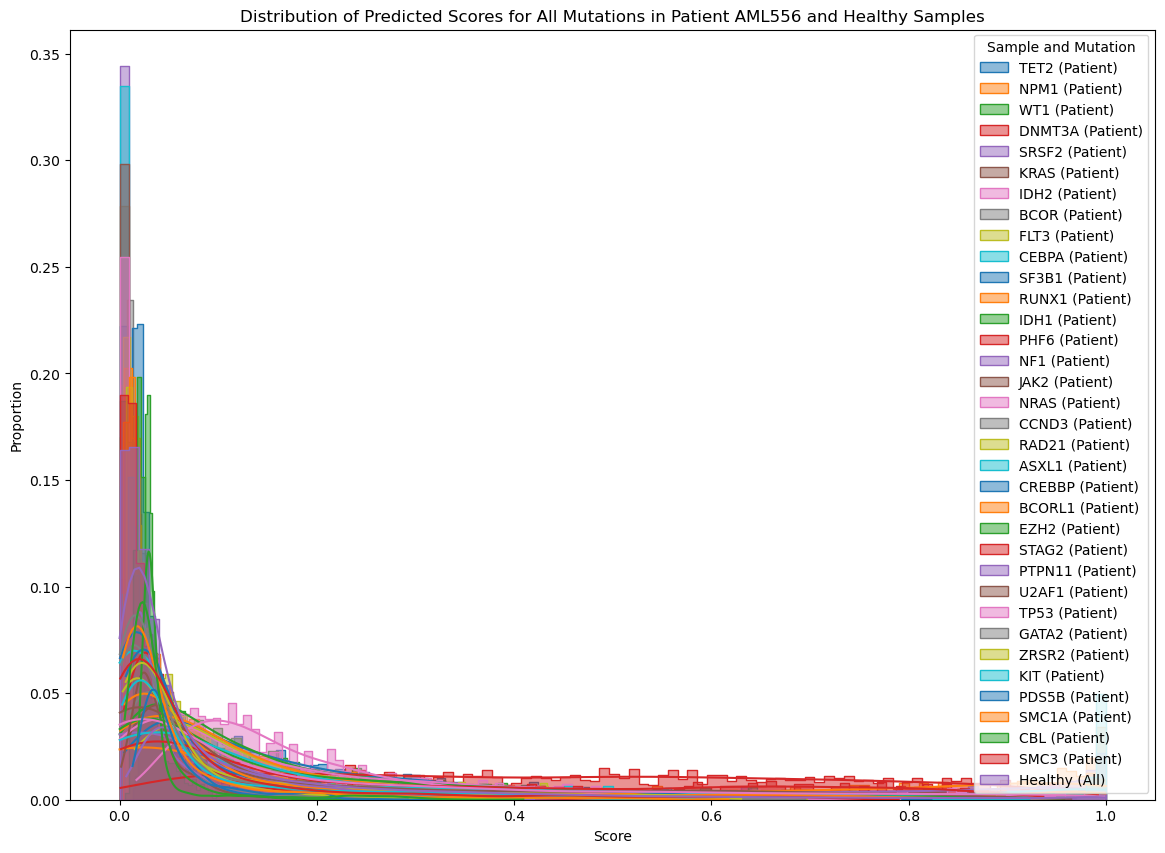

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# User specifies the patient to analyze
#specific_patient = 'AML1012'  # Replace with the patient ID you want to analyze
specific_patient = 'AML556' 

# Function to extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Filter for the specific patient and healthy samples
patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]
healthy_data = scRNA_data[scRNA_data.obs['Patient'].str.startswith('BM')]

# Identify all mutation score columns (assuming they start with 'ridge_preds_')
mutation_columns = [col for col in scRNA_data.obs.columns if col.startswith('ridge_preds_')]

# Create a DataFrame to hold scores for all mutations
all_mutation_scores = pd.DataFrame()

for mutation in mutation_columns:
    mutation_name = mutation.replace('ridge_preds_', '')
    patient_scores = patient_data.obs[mutation]
    healthy_scores = healthy_data.obs[mutation]
    
    temp_df_patient = pd.DataFrame({
        'Scores': patient_scores,
        'Mutation': mutation_name,
        'Sample': 'Patient'
    })
    
    temp_df_healthy = pd.DataFrame({
        'Scores': healthy_scores,
        'Mutation': mutation_name,
        'Sample': 'Healthy'
    })
    
    all_mutation_scores = pd.concat([all_mutation_scores, temp_df_patient, temp_df_healthy])

# Pool all healthy sample scores into a single distribution
pooled_healthy_scores = all_mutation_scores[all_mutation_scores['Sample'] == 'Healthy']['Scores']

# Create a DataFrame for pooled healthy scores
pooled_healthy_df = pd.DataFrame({
    'Scores': pooled_healthy_scores,
    'Sample': 'Healthy'
})

# Plot the distribution of scores for all mutations in the specific patient and pooled healthy samples
plt.figure(figsize=(14, 10))

# Plot each mutation for the patient
for mutation_name in all_mutation_scores['Mutation'].unique():
    sns.histplot(
        data=all_mutation_scores[(all_mutation_scores['Mutation'] == mutation_name) & (all_mutation_scores['Sample'] == 'Patient')],
        x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label=f'{mutation_name} (Patient)'
    )

# Plot the pooled healthy sample scores
sns.histplot(
    data=pooled_healthy_df,
    x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label='Healthy (All)'
)

plt.title(f'Distribution of Predicted Scores for All Mutations in Patient {specific_patient} and Healthy Samples')
plt.xlabel('Score')
plt.ylabel('Proportion')
plt.legend(title='Sample and Mutation')
plt.show()



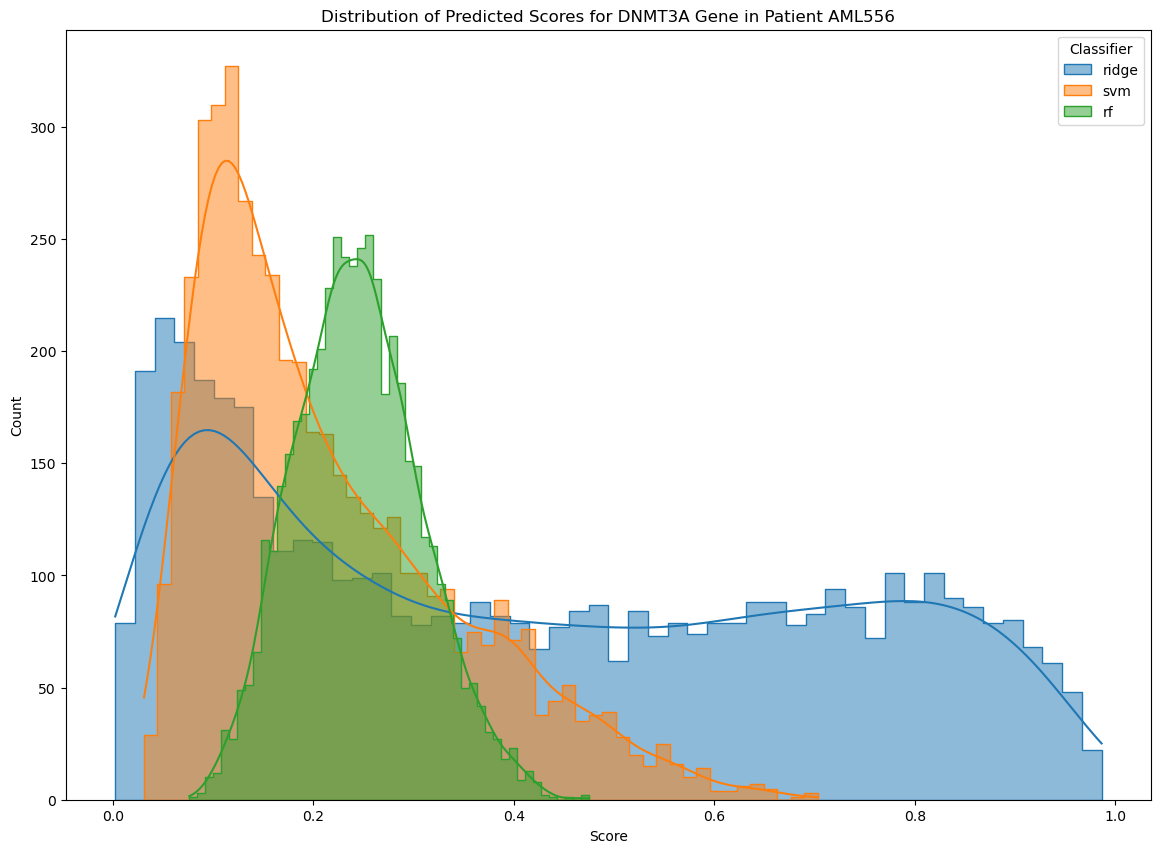

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# User specifies the patient and gene to analyze
specific_patient = 'AML556'  # Replace with the patient ID you want to analyze
#specific_gene = 'TET2'  # Replace with the gene you want to analyze
specific_gene = 'DNMT3A'  

# Function to extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Filter for the specific patient
patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]

# Define the classifiers to check
classifiers = ['ridge', 'svm', 'rf']  # Replace with your classifier names if different
#classifiers = ['ridge']

# Create a DataFrame to hold scores for the specific gene from all classifiers
all_classifier_scores = pd.DataFrame()

for classifier in classifiers:
    column_name = f'{classifier}_preds_{specific_gene}'
    if column_name in patient_data.obs.columns:
        scores = patient_data.obs[column_name]
        temp_df = pd.DataFrame({
            'Scores': scores,
            'Classifier': classifier
        })
        all_classifier_scores = pd.concat([all_classifier_scores, temp_df])

# Plot the distribution of scores for the specific gene from all classifiers
plt.figure(figsize=(14, 10))

# Plot each classifier separately to ensure labels are included
for classifier in classifiers:
    sns.histplot(
        data=all_classifier_scores[all_classifier_scores['Classifier'] == classifier],
        x='Scores', kde=True, element='step', stat='count', common_norm=False, bins=50, label=classifier
    )

plt.title(f'Distribution of Predicted Scores for {specific_gene} Gene in Patient {specific_patient}')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend(title='Classifier')
plt.show()


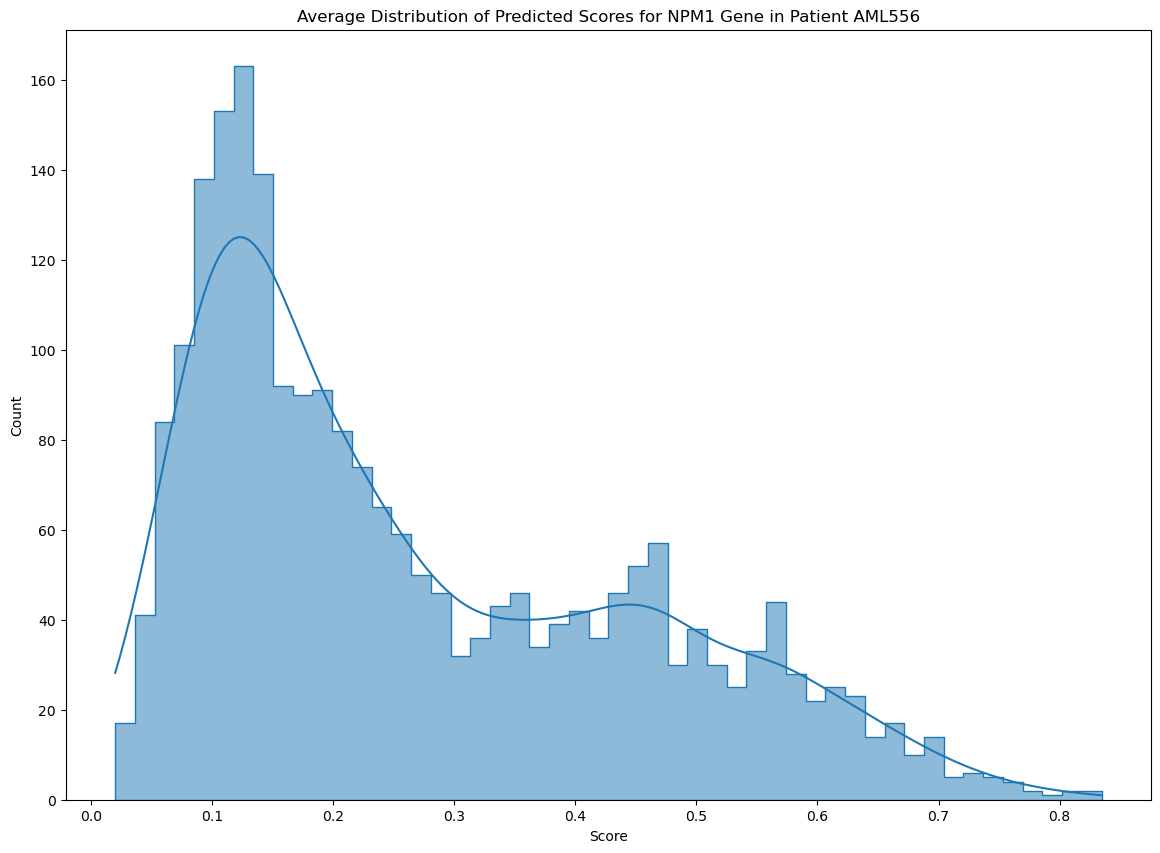

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

# User specifies the patient and gene to analyze
specific_patient = 'AML556'  # Replace with the patient ID you want to analyze
specific_gene = 'NPM1'       # Replace with the gene you want to analyze

# Function to extract patient information from observation indices
def extract_patient_id(index):
    match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
    return match.group(0) if match else 'Unknown'

scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

# Filter for the specific patient
patient_data = scRNA_data[scRNA_data.obs['Patient'] == specific_patient]

# Define the classifiers to check
classifiers = ['ridge', 'svm', 'rf']  # Replace with your classifier names if different

# Create a DataFrame to hold scores for the specific gene from all classifiers
all_classifier_scores = pd.DataFrame(index=patient_data.obs.index)

for classifier in classifiers:
    column_name = f'{classifier}_preds_{specific_gene}'
    if column_name in patient_data.obs.columns:
        all_classifier_scores[classifier] = patient_data.obs[column_name]

# Calculate the average score across all classifiers for each cell
all_classifier_scores['Average_Score'] = all_classifier_scores.mean(axis=1)

# Plot the distribution of the average scores for the specific gene in the specific patient
plt.figure(figsize=(14, 10))
sns.histplot(all_classifier_scores['Average_Score'], kde=True, element='step', stat='count', common_norm=False, bins=50)
plt.title(f'Average Distribution of Predicted Scores for {specific_gene} Gene in Patient {specific_patient}')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()



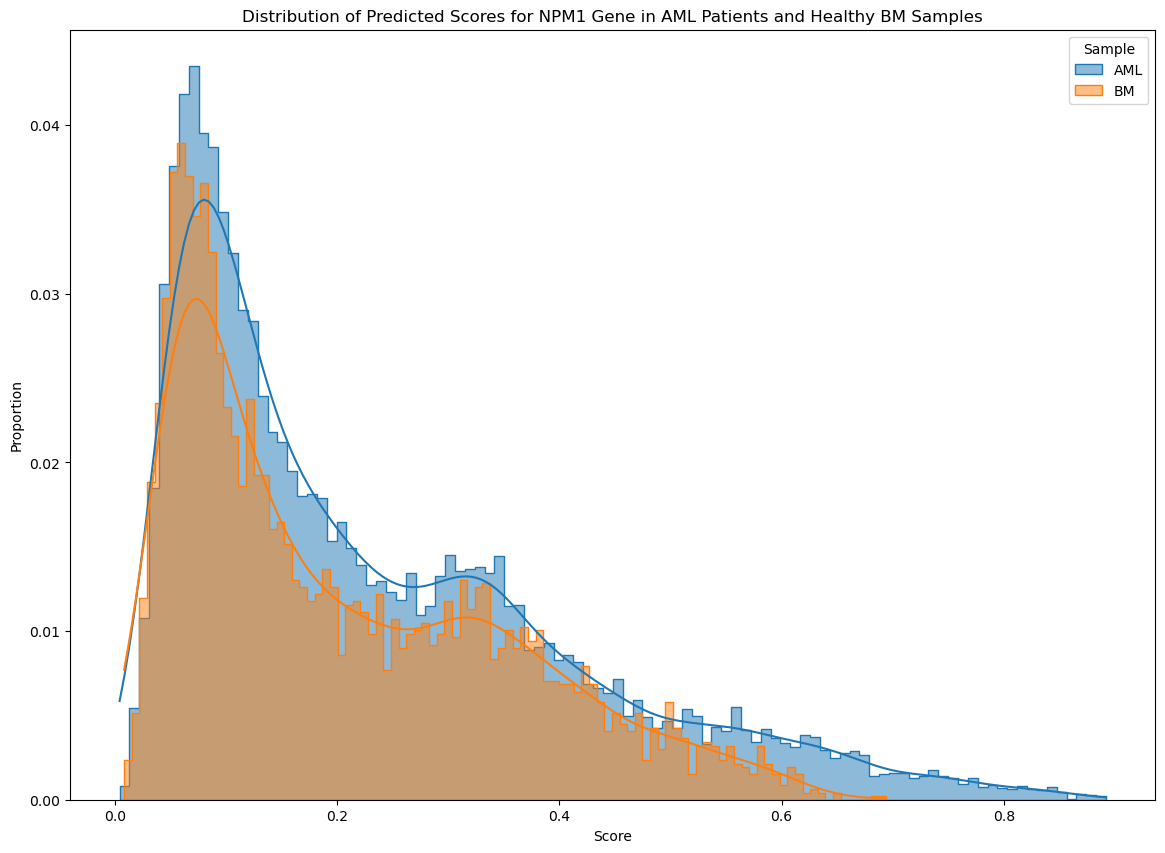

In [533]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

def plot_gene_prediction_distribution(scRNA_data, specific_gene):
    # Function to extract patient information from observation indices
    def extract_patient_id(index):
        match = re.match(r'(BM\d+|AML\d+[A-Z]?)', index)
        return match.group(0) if match else 'Unknown'

    scRNA_data.obs['Patient'] = scRNA_data.obs.index.map(extract_patient_id)

    # Extract predicted mutation status probabilities for the specific gene
    predicted_probs = scRNA_data.obs[f'ensemble_preds_{specific_gene}']

    # Convert raw scores to probabilities if necessary
    # if predicted_probs.min() < 0 or predicted_probs.max() > 1:
    #    predicted_probs = 1 / (1 + np.exp(-predicted_probs))

    # Filter scores for AML patients and healthy BM samples
    aml_scores = predicted_probs[scRNA_data.obs['Patient'].str.startswith('AML')]
    bm_scores = predicted_probs[scRNA_data.obs['Patient'].str.startswith('BM')]

    # Create a DataFrame for easier plotting with seaborn
    scores_df = pd.DataFrame({
        'Scores': np.concatenate([aml_scores, bm_scores]),
        'Sample': ['AML'] * len(aml_scores) + ['BM'] * len(bm_scores)
    })

    # Plot the distribution of scores for the specified gene
    plt.figure(figsize=(14, 10))
    sns.histplot(data=scores_df[scores_df['Sample'] == 'AML'], x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label='AML')
    sns.histplot(data=scores_df[scores_df['Sample'] == 'BM'], x='Scores', kde=True, element='step', stat='proportion', common_norm=False, bins=100, label='BM')
    
    # Manually add the legend
    plt.legend(title='Sample')

    plt.title(f'Distribution of Predicted Scores for {specific_gene} Gene in AML Patients and Healthy BM Samples')
    plt.xlabel('Score')
    plt.ylabel('Proportion')
    plt.show()

# Example usage
specific_gene = 'NPM1'  # Replace with the gene you want to analyze
plot_gene_prediction_distribution(scRNA_data, specific_gene)



#### Check predictions versus ground-truth detected mutations in single-cell genotyping calls

In [ ]:
# Specify the directory and filename of the ground truth single-cell mutations
mut_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/testing/vanGalen_D0_AML_samples_and_4_healthy_BM_samples/'
mut_tsv_file = 'barcode_mut_transcripts.tsv'


In [ ]:
# Read in ground truth single cell mutations to dataframe
sc_mut_ground_truth = pd.read_csv(mut_dir + mut_tsv_file, sep='\t')


In [ ]:
print(sc_mut_ground_truth)
#print(set(sc_mut_ground_truth['Barcode']))


In [ ]:
# Select which patient and mutation to analyze
#patient = 'AML419A.D0_'
#patient = 'AML1012.D0_'
#patient = 'AML556.D0_'
#patient = 'AML419A'
#patient = 'AML556'
patient = ''
mutation = 'NPM1'
#mutation = 'DNMT3A'
#mutation = 'NRAS'


In [ ]:
filtered_df = sc_mut_ground_truth[sc_mut_ground_truth['Barcode'].str.contains(patient)]
print(filtered_df)


In [ ]:
filtered_df['MutTranscripts'] = filtered_df['MutTranscripts'].fillna('')
filtered_df['WtTranscripts'] = filtered_df['WtTranscripts'].fillna('')


In [ ]:
filtered_df[filtered_df['MutTranscripts'].str.contains(mutation)]
print(filtered_df)


In [ ]:
# Filter based on the mutation being in either MutTranscripts or WtTranscripts
# This should eliminate those cells which weren't checked for the mutation of interest
mutation_filtered_df = filtered_df[
    filtered_df['MutTranscripts'].str.contains(mutation) | 
    filtered_df['WtTranscripts'].str.contains(mutation)
]


In [ ]:
# Print the filtered dataframe
print(mutation_filtered_df)


In [ ]:
# Extract predicted mutation status probabilities
#predicted_probs = scRNA_data.obs[f'ridge_preds_{mutation}']
predicted_probs = scRNA_data.obs[f'ensemble_preds_{mutation}']
#predicted_probs = scRNA_data.obs[f'svm_preds_{mutation}']

# All mutations
#predicted_probs = scRNA_data.obs


In [ ]:
predicted_probs = predicted_probs[predicted_probs.index.str.contains(patient)]
print(predicted_probs.index)


In [ ]:
print(predicted_probs)
print(min(predicted_probs))
print(max(predicted_probs))


In [ ]:
#threshold = .75
#predicted_probs_above_thresh = predicted_probs[predicted_probs >= threshold]


In [ ]:
#print(predicted_probs_above_thresh)


In [ ]:
print(mutation_filtered_df)


In [ ]:
# Remove the '-0' suffix from all indices
#predicted_scores.index = predicted_scores.index.str.replace('-0$', '', regex=True)


In [ ]:
#print(predicted_scores)
#print(type(predicted_scores))


In [ ]:
#for index in predicted_scores.index:
#    print(predicted_scores.loc[index])


In [ ]:
#print(mutation_filtered_df)


In [ ]:
# Remove the '-0' suffix from all indices
predicted_probs.index = predicted_probs.index.str.replace('-0$', '', regex=True)

print(predicted_probs)


In [ ]:
'''
# Old version
transcript_dict = {'Mutant': [], 'Wildtype': []}

# Iterate through the DataFrame using iterrows()
for index, row in mutation_filtered_df.iterrows():
    if row['MutTranscripts'] != '' and row['WtTranscripts'] == '':
        print(row['Barcode'])
        print('Mutant transcript: ' + row['MutTranscripts'])
        print('WT transcript: ' + row['WtTranscripts'])
        if row['Barcode'] in predicted_probs.index:
            print('Predicted mutation score: ' + str(predicted_probs.loc[row['Barcode']]))
            transcript_dict['Mutant'].append(predicted_probs.loc[row['Barcode']])
        else:
            print('No mutation predicted for this cell!')
    if row['WtTranscripts'] != '' and row['MutTranscripts'] == '':
        transcript_dict['Wildtype'].append(predicted_probs.loc[row['Barcode']])
'''

In [ ]:
transcript_dict = {'Mutant': [], 'Wildtype': []}

# Iterate through the DataFrame using iterrows()
for index, row in mutation_filtered_df.iterrows():
    barcode = row['Barcode']
    #barcode_with_suffix = barcode + '-scRNA'
    barcode_with_suffix = barcode
    
    #if row['MutTranscripts'] != '' and row['WtTranscripts'] == '':
    if row['MutTranscripts'] != '':
        print(barcode)
        print('Mutant transcript: ' + row['MutTranscripts'])
        print('WT transcript: ' + row['WtTranscripts'])
        
        if barcode in predicted_probs.index or barcode_with_suffix in predicted_probs.index:
            if barcode in predicted_probs.index:
                predicted_score = predicted_probs.loc[barcode]
            else:
                predicted_score = predicted_probs.loc[barcode_with_suffix]
            
            print('Predicted mutation score: ' + str(predicted_score))
            transcript_dict['Mutant'].append(predicted_score)
        else:
            print('No mutation predicted for this cell!')
    
    #if row['WtTranscripts'] != '' and row['MutTranscripts'] == '':
    if row['WtTranscripts'] != '':
        if barcode in predicted_probs.index or barcode_with_suffix in predicted_probs.index:
            if barcode in predicted_probs.index:
                predicted_score = predicted_probs.loc[barcode]
            else:
                predicted_score = predicted_probs.loc[barcode_with_suffix]
                
            transcript_dict['Wildtype'].append(predicted_score)


In [ ]:
print(transcript_dict)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Convert the data to a DataFrame for easier plotting
df = pd.DataFrame({
    'Value': transcript_dict['Mutant'] + transcript_dict['Wildtype'],
    'Type': ['Mutant'] * len(transcript_dict['Mutant']) + ['Wildtype'] * len(transcript_dict['Wildtype'])
})

# Plot the distributions
plt.figure(figsize=(12, 8))
sns.histplot(df[df['Type'] == 'Mutant']['Value'], color='blue', stat='proportion', kde=True, label='Mutant', bins=100)
sns.histplot(df[df['Type'] == 'Wildtype']['Value'], color='green', stat='proportion', kde=True, label='Wildtype', bins=100)
#sns.histplot(df[df['Type'] == 'Mutant']['Value'], color='blue', stat='count', kde=True, label='Mutant', bins=30)
#sns.histplot(df[df['Type'] == 'Wildtype']['Value'], color='green', stat='count', kde=True, label='Wildtype', bins=30)

# Customize the plot
plt.title('Distribution of NPM1 mutant versus wildtype samples in all single-cell mutation calls')
plt.xlabel('Values')
plt.ylabel('Proportion')
#plt.ylabel('Count')
plt.legend()

# Show the plot
plt.show()



In [ ]:
transcript_dict = {'Mutant': [], 'Wildtype': [], 'Both': []}

# Iterate through the DataFrame using iterrows()
for index, row in mutation_filtered_df.iterrows():
    barcode = row['Barcode']
    barcode_with_suffix = barcode
    
    if row['MutTranscripts'] != '' and row['WtTranscripts'] == '':
        if barcode in predicted_probs.index or barcode_with_suffix in predicted_probs.index:
            if barcode in predicted_probs.index:
                predicted_score = predicted_probs.loc[barcode]
            else:
                predicted_score = predicted_probs.loc[barcode_with_suffix]
                
            transcript_dict['Mutant'].append(predicted_score)
        else:
            print('No mutation predicted for this cell!')
    
    elif row['WtTranscripts'] != '' and row['MutTranscripts'] == '':
        if barcode in predicted_probs.index or barcode_with_suffix in predicted_probs.index:
            if barcode in predicted_probs.index:
                predicted_score = predicted_probs.loc[barcode]
            else:
                predicted_score = predicted_probs.loc[barcode_with_suffix]
                
            transcript_dict['Wildtype'].append(predicted_score)
            
    elif row['MutTranscripts'] != '' and row['WtTranscripts'] != '':
        if barcode in predicted_probs.index or barcode_with_suffix in predicted_probs.index:
            if barcode in predicted_probs.index:
                predicted_score = predicted_probs.loc[barcode]
            else:
                predicted_score = predicted_probs.loc[barcode_with_suffix]
                
            transcript_dict['Both'].append(predicted_score)
        else:
            print('No mutation predicted for this cell!')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the data to a DataFrame for easier plotting
df = pd.DataFrame({
    'Value': transcript_dict['Mutant'] + transcript_dict['Wildtype'] + transcript_dict['Both'],
    'Type': ['Mutant'] * len(transcript_dict['Mutant']) + ['Wildtype'] * len(transcript_dict['Wildtype']) + ['Both'] * len(transcript_dict['Both'])
})

# Plot the distributions
plt.figure(figsize=(12, 8))
sns.histplot(df[df['Type'] == 'Mutant']['Value'], color='blue', stat='proportion', kde=True, label='Mutant', bins=100)
sns.histplot(df[df['Type'] == 'Wildtype']['Value'], color='green', stat='proportion', kde=True, label='Wildtype', bins=100)
sns.histplot(df[df['Type'] == 'Both']['Value'], color='orange', stat='proportion', kde=True, label='Both', bins=100)

# Customize the plot
plt.title('Distribution of NPM1 mutant versus wildtype samples in all single-cell mutation calls')
plt.xlabel('Values')
plt.ylabel('Proportion')
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Save the results AnnData object
save_dir = '/home/groups/precepts/ashforda/scOPE_github_stuff/data/testing/vanGalen_all_h5ad/'
scRNA_data.write(save_dir + '1000_variable_features_scRNA-seq_prediction_probabilities_256gb_memory_run.h5ad')
